# All the function in EVRP

All the code in here are originated from the code in the TR-EVRP-Competition with some modification.

In [1]:
# Import all the necessary library
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Choose setup

# Initial construction Nearest Neighbour, Clarke Wright Saving or Minimum Spanning Tree (1|2|3)
initial_construction_choice = 2

# VND random or not (1|2)
VND_randomize = 2

# Use AFS reallcation or not (1|2)
use_AFS_operator = 1

In [3]:
# To see path
see_path = True

## For statistic

In [4]:
# initialiazes a run for your heuristic
def start_run(r: int):
    random.seed(r)  # Random seed
    init_evals()
    init_current_best()
    print("Run: {} with random seed {}".format(r, r))


# gets an observation of the run for your heuristic
def end_run(r: int):
    get_mean(r - 1, get_current_best())
    print("End of run {} with best solution quality {} total evaluations: {}".format(r, get_current_best(), get_evals()))


# sets the termination conidition for your heuristic
def termination_condition():
    flag = False

    if get_evals() >= TERMINATION:
        flag = True
    return flag

In [5]:
def open_stats():
    global perf_of_trials
    global perf_filename
    global log_performance
    global MAX_TRIALS

    # Initialize
    perf_of_trials = [0.0] * MAX_TRIALS

    # get problem name
    name = (problem_instance.split('\\')[-1]).split('.')[0]

    # initialize and open output files
    perf_filename = "results\{}.txt".format(name)

    # for performance
    try:
        log_performance = open(perf_filename, mode='w', encoding='UTF-8')
    except:
        raise Exception("Can't open file")


# initialize and open output files


def get_mean(r: int, value: float):
    global perf_of_trials
    perf_of_trials[r] = value


def mean(values, size: int):
    m = 0.0
    for i in range(size):
        m += values[i]

    m = m / float(size)
    return m  # mean


def stdev(values, size: int, average: float):
    dev = 0.0

    if size <= 1:
        return 0.0
    for i in range(size):
        dev += (float(values[i]) - average) * (float(values[i]) - average)
    return math.sqrt(dev / float(size - 1))  # standard deviation


def best_of_vector(values, l: int):
    k = 0
    min = values[k]

    for k in range(1, l):
        if values[k] < min:
            min = values[k]

    return min


def worst_of_vector(values, l: int):
    k = 0
    max = values[k]

    for k in range(1, l):
        if values[k] > max:
            max = values[k]

    return max


def close_stats():
    global MAX_TRIALS
    global log_performance
    global perf_of_trials

    # For statistics
    for i in range(MAX_TRIALS):
        log_performance.write("{0:.2f}".format(perf_of_trials[i]))
        log_performance.write("\n")

    perf_mean_value = mean(perf_of_trials, MAX_TRIALS)
    perf_stdev_value = stdev(perf_of_trials, MAX_TRIALS, perf_mean_value)

    log_performance.write("Mean: {0:.5f}".format(perf_mean_value))
    log_performance.write("\n")
    log_performance.write("Std Dev: {0:.5f}".format(perf_stdev_value))
    log_performance.write("\n")
    log_performance.write("Min: {0:.5f}".format(best_of_vector(perf_of_trials, MAX_TRIALS)))
    log_performance.write("\n")
    log_performance.write("Max: {0:.5f}".format(worst_of_vector(perf_of_trials, MAX_TRIALS)))
    log_performance.write("\n")

    log_performance.close()

## For EVRP

In [6]:
'''
/****************************************************************/
/*Compute and return the euclidean distance of two objects      */
/****************************************************************/
'''


def euclidean_distance(i: int, j: int):
    xd = node_list[i][1] - node_list[j][1]
    yd = node_list[i][2] - node_list[j][2]
    r = math.sqrt(xd * xd + yd * yd)
    return r


'''
/****************************************************************/
/*Compute the distance matrix of the problem instance           */
/****************************************************************/
'''


def compute_distances():
    global distances

    for i in range(ACTUAL_PROBLEM_SIZE):
        for j in range(ACTUAL_PROBLEM_SIZE):
            distances[i][j] = euclidean_distance(i, j)


'''
/****************************************************************/
/*Generate and return a two-dimension array of type double      */
/****************************************************************/
'''


def generate_2D_matrix_double(n: int, m: int):
    matrix = [[0.0 for i in range(n)] for j in range(m)]
    return matrix


'''
/****************************************************************/
/* Read the problem instance and generate the initial object    */
/* vector.                                                      */
/****************************************************************/
'''


def read_problem(filename: str):
    global problem_size
    global MAX_CAPACITY
    global MIN_VEHICLES
    global BATTERY_CAPACITY
    global energy_consumption
    global NUM_OF_STATIONS
    global OPTIMUM
    global NUM_OF_CUSTOMERS
    global node_list
    global ACTUAL_PROBLEM_SIZE
    global TERMINATION
    global distances
    global cust_demand
    global charging_station
    global DEPOT
    global CUSTOMER_START_INDEX
    global STATION_START_INDEX

    keywords = ""

    with open(filename, mode='r', encoding='UTF-8') as file:
        contents = file.readlines()
        for line in contents:
            word = line.split()

            if word[0] == "DIMENSION:":
                problem_size = int(word[1])
            elif word[0] == "CAPACITY:":
                MAX_CAPACITY = int(word[1])
            elif word[0] == "VEHICLES:":
                MIN_VEHICLES = int(word[1])
            elif word[0] == "ENERGY_CAPACITY:":
                BATTERY_CAPACITY = int(word[1])
            elif word[0] == "ENERGY_CONSUMPTION:":
                energy_consumption = float(word[1])
            elif word[0] == "STATIONS:":
                NUM_OF_STATIONS = int(word[1])
                NUM_OF_CUSTOMERS = problem_size - 1
                ACTUAL_PROBLEM_SIZE = problem_size + NUM_OF_STATIONS
            elif word[0] == "OPTIMAL_VALUE:":
                OPTIMUM = float(word[1])
            elif word[0] == "NODE_COORD_SECTION":
                keywords = "NODE_COORD_SECTION"
                distances = generate_2D_matrix_double(ACTUAL_PROBLEM_SIZE, ACTUAL_PROBLEM_SIZE)
                continue
            elif word[0] == "DEMAND_SECTION":
                keywords = "DEMAND_SECTION"
                cust_demand = [0] * ACTUAL_PROBLEM_SIZE
                charging_station = [False] * ACTUAL_PROBLEM_SIZE
                continue
            elif word[0] == "STATIONS_COORD_SECTION":
                keywords = "STATIONS_COORD_SECTION"
                continue
            elif word[0] == "DEPOT_SECTION":
                keywords = "DEPOT_SECTION"
                continue
            elif word[0] == '-1':
                break

            if keywords == "NODE_COORD_SECTION":
                if problem_size != 0:  # problem_size is the number of customers plus the depot
                    # store initial objects
                    node_list.append([int(word[0]) - 1, float(word[1]), float(word[2])])
                else:
                    print("Error in NODE_COORD_SECTION!!!")
                    exit(0)
            elif keywords == "DEMAND_SECTION":
                if problem_size != 0:
                    cust_demand[int(word[0]) - 1] = int(word[1])
                    if CUSTOMER_START_INDEX == 0:
                        CUSTOMER_START_INDEX = int(word[0]) - 1
            elif keywords == "STATIONS_COORD_SECTION":
                if problem_size != 0:
                    charging_station[int(word[0]) - 1] = True
                    if STATION_START_INDEX == 0:
                        STATION_START_INDEX = int(word[0]) - 1
            elif keywords == "DEPOT_SECTION":
                DEPOT = int(word[0]) - 1
                charging_station[int(word[0]) - 1] = True

    TERMINATION = 25000 * ACTUAL_PROBLEM_SIZE
    compute_distances()


'''
/****************************************************************/
/* Returns the solution quality of the solution. Taken as input */
/* an array of node indeces and its length                      */
/****************************************************************/
'''


def fitness_evaluation(routes, size: int):
    global distances
    global current_best
    global best_routes
    global evals

    tour_length = 0.0

    """	
    The format of the solution that this method evaluates is the following
    Node id:  0 - 5 - 6 - 8 - 0 - 1 - 2 - 3 - 4 - 0 - 7 - 0
    Route id: 1 - 1 - 1 - 1 - 2 - 2 - 2 - 2 - 2 - 3 - 3 - 3
    this solution consists of three routes: 
    Route 1: 0 - 5 - 6 - 8 - 0
    Route 2: 0 - 1 - 2 - 3 - 4 - 0
    Route 3: 0 - 7 - 0
    """

    for i in range(size - 1):
        tour_length += distances[routes[i]][routes[i + 1]]

    if tour_length < current_best:
        current_best = tour_length
        best_routes = routes

    # adds complete evaluation to the overall fitness evaluation count
    evals += 1
    return tour_length


'''
/****************************************************************/
/* Outputs the routes of the solution. Taken as input           */
/* an array of node indeces and its length                      */
/****************************************************************/
'''


def print_solution(routes, size: int):
    for i in range(size):
        print(routes[i], sep=', ')
    print()


'''
/****************************************************************/
/* Returns the distance between two points: from and to. Can be */
/* used to evaluate a part of the solution. The fitness         */
/* evaluation count will be proportional to the problem size    */
/****************************************************************/
'''


def get_distance(_from: int, _to: int):
    global evals
    global ACTUAL_PROBLEM_SIZE
    global distances

    # adds partial evaluation to the overall fitness evaluation count
    # It can be used when local search is used and a whole evaluation is not necessary
    evals += (1.0 / ACTUAL_PROBLEM_SIZE)
    return distances[_from][_to]


'''
/****************************************************************/
/* Returns the energy consumed when travelling between two      */
/* points: from and to.                                         */
/****************************************************************/
'''


def get_energy_consumption(_from: int, _to: int):
    global energy_consumption
    global distances

    # DO NOT USE THIS FUNCTION MAKE ANY CALCULATIONS TO THE ROUTE COST
    return energy_consumption * distances[_from][_to]


'''
/****************************************************************/
/* Returns the demand for a specific customer                   */
/* points: from and to.                                         */
/****************************************************************/
'''


def get_customer_demand(customer: int):
    global cust_demand
    return cust_demand[customer]


'''
/****************************************************************/
/* Returns true when a specific node is a charging station;     */
/* and false otherwise                                          */
/****************************************************************/
'''


def is_charging_station(node: int):
    global charging_station

    flag = False
    if charging_station[node]:
        flag = True
    return flag


'''
/****************************************************************/
/* Returns the best solution quality so far                     */
/****************************************************************/
'''


def get_current_best():
    global current_best
    return current_best


def get_current_best_route():
    global best_routes
    return best_routes


'''
/*******************************************************************/
/* Reset the best solution quality so far for a new indepedent run */
/*******************************************************************/
'''


def init_current_best():
    global current_best
    global best_routes
    current_best = float('inf')
    best_routes = []


'''
/****************************************************************/
/* Returns the current count of fitness evaluations             */
/****************************************************************/
'''


def get_evals():
    global evals
    return evals


'''
/****************************************************************/
/* Reset the evaluation counter for a new indepedent run        */
/****************************************************************/
'''


def init_evals():
    global evals
    evals = 0.0


'''
/****************************************************************/
/* Validates the routes of the solution. Taken as input         */
/* an array of node indeces and its length                      */
/****************************************************************/
'''


def check_solution(t, size: int):
    global BATTERY_CAPACITY
    global MAX_CAPACITY
    global DEPOT
    global NUM_OF_CUSTOMERS

    energy_temp = BATTERY_CAPACITY
    capacity_temp = MAX_CAPACITY
    number_of_customers = 0
    distance_temp = 0.0

    for i in range(size - 1):
        _from = t[i]
        _to = t[i + 1]
        capacity_temp -= get_customer_demand(_to)
        energy_temp -= get_energy_consumption(_from, _to)
        distance_temp += get_distance(_from, _to)

        if get_customer_demand(_to) > 0:
            number_of_customers += 1

        if capacity_temp < 0.0:
            print("error: capacity below 0 at customer {}".format(_to))
            print_solution(t, size)
            exit(1)
        if energy_temp < 0.0:
            print("error: energy below 0 from {} to {}".format(_from, _to))
            print_solution(t, size)
            exit(1)
        if _to == DEPOT:
            capacity_temp = MAX_CAPACITY
        if is_charging_station(_to) or _to == DEPOT:
            energy_temp = BATTERY_CAPACITY

    if distance_temp != fitness_evaluation(t, size):
        print("error: check fitness evaluation")
    if number_of_customers != NUM_OF_CUSTOMERS:
        print("error: not visit all the customer")

## For heuristic

The ideal behind this heuristic is heavily inspired by the report *D. Woller, et al 'Electric Vehicle Routing Problem'* (https://cw.fel.cvut.cz/wiki/_media/courses/ko/evrp_kozak.pdf)

### **Metaheuristic**

- This section hold all the function to run the heuristic
- We use meta-heuristic to solve the EVRP problem 
- Meta-heuristic has two characteristics: intensification and diversification 
	- For diversification we use Variable Neighborhood Search (VNS)
	  - In perturbation we randomly use shuffle, invert and reconnect to create a new path, then repair it using SSF
	- For intensification we use (Randomized)Variable Neighborhood Descent as local search
	  - The operator for local search are: exchange, relocation, two-opt, or-opt and AFS reallocation

In [7]:
def initialize_heuristic():
	pass


# implement your heuristic in this function
def run_heuristic():
	# Construct initial solution
	current_route = initial_construction()
	stop = False

	while not stop:
		perm_route = perturbation(current_route)
		new_route = seperate_sequential_fixing(perm_route)

		new_route, stop = local_search(new_route)

		if fitness_evaluation(new_route, len(new_route)) < fitness_evaluation(current_route, len(current_route)):
			current_route = new_route


def local_search(solution_route: list):
  global TERMINATION
  global evals
  global VND_randomize
  global use_AFS_operator

  i = 0
  stop = False
  current_route = solution_route[:]

  if use_AFS_operator == 1:
    choice = [1, 2, 3, 4, 5]
  else:
    choice = [1, 2, 3, 4]

  if VND_randomize == 1:
    random.shuffle(choice)

  while i < len(choice):
    method = choice[i]

    if method == 1:
      new_route = relocate(current_route, len(current_route))
    elif method == 2:
      new_route = exchange(current_route, len(current_route))
    elif method == 3:
      new_route = two_opt(current_route, len(current_route))
    elif method == 4:
      new_route = or_opt(current_route, len(current_route))
    else:
      new_route = AFS_reallocation(current_route, len(current_route))

    if fitness_evaluation(new_route, len(new_route)) < fitness_evaluation(current_route, len(current_route)):
      current_route = new_route
      i = 0
      if VND_randomize == 1:
        random.shuffle(choice)
    else:
      i += 1

    if evals >= TERMINATION:
      stop = True
      break

  return current_route, stop


def initial_construction():
  global initial_construction_choice

  # 2 phase construction
  if initial_construction_choice == 1:
    initial_solution = nearest_neighbour()
  elif initial_construction_choice == 2:
    initial_solution = clarke_wright_saving()
  else:
    initial_solution = minimum_spanning_tree()

  repaired_solution = seperate_sequential_fixing(initial_solution)

  return repaired_solution


def perturbation(solution_route: list):
	length = len(solution_route)
	routes = []
	new_route = []
	random_index = random.sample(range(length), PERTURBATION_NUM)
	random_index.sort()

	start_index = 0
	end_index = length

	# Get route in solution based on random index
	for p in random_index:
		routes.append(solution_route[start_index:p])
		start_index = p

	routes.append(solution_route[start_index:end_index])

	# Random do nothing, shuffle and invert
	random_choice = ['nothing', 'shuffle', 'invert']

	for route in routes:
		choice = random.choice(random_choice)

		if choice == 'shuffle':
			random.shuffle(route)
		elif choice == 'invert':
			route.reverse()

	list_number = list(range(PERTURBATION_NUM + 1))
	random.shuffle(list_number)

	# Randomly reconnecting route
	for i in list_number:
		new_route += routes[i]

	# Make sure the begin and the end are depot
	if new_route[0] != 0:
		new_route.insert(0, 0)
	if new_route[-1] != 0:
		new_route.append(0)

	# Remove any redundancy in the solution
	new_route = remove_duplicate_node(new_route)

	return new_route


def remove_duplicate_node(solution_route: list):
	index = 0

	while index < len(solution_route) - 1:
		if solution_route[index] == solution_route[index + 1]:
			del solution_route[index + 1]
			continue
		index += 1

	return solution_route


### **Initial construction**

Each of these method below will produce a tour that go to all the customer regard or disregarding the capacity and battery's level constraints. It starts from depot and also ends with depot.

In [8]:
# Initial construction method
# Source: https://stemlounge.com/animated-algorithms-for-the-traveling-salesman-problem/
def nearest_neighbour():
  global NUM_OF_CUSTOMERS

  nn_solution = []
  un_visited = list(range(1, NUM_OF_CUSTOMERS + 1))

  nn_solution.append(0)

  while True:
    if not un_visited:
      break

    last_node_index = nn_solution[-1]
    current_best = 2**32 - 1
    current_index_route = 0
    current_index = 0

    for index, value in enumerate(un_visited):
      distance = get_distance(last_node_index, value)

      if distance < current_best:
        current_best = distance
        current_index_route = value
        current_index = index

    nn_solution.append(current_index_route)
    del un_visited[current_index]

  nn_solution.append(0)

  return nn_solution

# Clarke Wright Saving
# Source: https://www.hindawi.com/journals/tswj/2013/874349/?fbclid=IwAR2iu67fgOu40-miFNZBhYTsKfkPUvwu2DKJ15wpqvKEZWHn7T4RZTuGes4
def clarke_wright_saving():
  global problem_size

  a = problem_size
  c = np.zeros((a, a))

  s = []
  for i in range(a):
    for j in range(a):
      if i != j:
        c[i][j] = get_distance(i, j)

  for i in range(a):
    for j in range(a):
      if i != j:
        s.append([i, j, c[0][i] + c[j][0] - c[i][j]])

  for i in range(len(s)):
    s.sort(key=lambda x: x[2], reverse=True)
  route = [0]

  size_s = len(s)
  for i in range(0, size_s):
    if s[i][0] not in route:
      route.append(s[i][0])
    if s[i][1] not in route:
      route.append(s[i][1])
  route.append(0)

  return route


# Minimum Spanning Tree
# Source: https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/?fbclid=IwAR0OSTRDZ6J_jFQ5LEHI_B60ZCP6Cx1S9jUB_jYSY6LgGOJHA8Q9DrEV9w0
class Graph:
    def __init__(self, vertices):
        self.V = vertices  # No. of vertices
        self.graph = []  # default dictionary

    # to store graph

    # function to add an edge to graph
    def addEdge(self, u, v, w):
        self.graph.append([u, v, w])

    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)

        # Attach smaller rank tree under root of
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot

        # If ranks are same, then make one as root
        # and increment its rank by one
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    # The main function to construct MST using Kruskal's
    # algorithm
    def KruskalMST(self):

        result = []  # This will store the resultant MST

        # An index variable, used for sorted edges
        i = 0

        # An index variable, used for result[]
        e = 0

        # Step 1: Sort all the edges in
        # non-decreasing order of their
        # weight. If we are not allowed to change the
        # given graph, we can create a copy of graph
        self.graph = sorted(self.graph,
                            key=lambda item: item[2])

        parent = []
        rank = []

        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
        route = [0]
        # Number of edges to be taken is equal to V-1
        while e < self.V - 1:

            # Step 2: Pick the smallest edge and increment
            # the index for next iteration
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)

            # If including this edge does't
            # cause cycle, include it in result
            # and increment the indexof result
            # for next edge
            if x != y:
                e = e + 1
                result.append([u, v, w])
                self.union(parent, rank, x, y)
        # Else discard the edge

        for x, y, w in result:
            if x not in route:
                route.append(x)
            if y not in route:
                route.append(y)
        route.append(0)

        return route


def minimum_spanning_tree():
    global problem_size

    size_of_node = problem_size
    Mst_algo = Graph(size_of_node)
    d = np.zeros((size_of_node, size_of_node))
    for i in range(size_of_node):
        for j in range(size_of_node):
            if i != j:
                d[i][j] = get_distance(i, j)

    for i in range(size_of_node):
        for j in range(size_of_node):
            if i != j:
                Mst_algo.addEdge(i, j, d[i][j])

    return Mst_algo.KruskalMST()

### **Repair method**

In [9]:
# Repair method
def seperate_sequential_fixing(solution_route: list):
  global cust_demand
  global MAX_CAPACITY
  global BATTERY_CAPACITY
  global DEPOT

  # First phase: check load constraint
  customers = cust_demand
  load_limit = MAX_CAPACITY
  temp_load = 0

  for index, value in enumerate(solution_route):
    if customers[value] <= 0:
      continue
    temp_load += customers[value]

    # If total load of the next customer exceed the limit then insert depot
    if temp_load > load_limit:
      solution_route.insert(index, 0)
      temp_load = 0

  # Second phase: check battery limit
  max_battery = BATTERY_CAPACITY
  temp_battery = max_battery
  add_battery_flag = False
  index = 1

  while index < len(solution_route):
    _from = solution_route[index-1]
    _to = solution_route[index]

    # If current is depot:
    if _from == DEPOT:
      temp_battery = BATTERY_CAPACITY

    # Check if nearest station can be reach from current and prevent infinity loop
    # Check nearest station in current node
    nearest_station = get_nearest_station(_from)
    temp_battery_station = temp_battery - get_energy_consumption(_from, nearest_station)
    # Check nearest station in next node
    nearest_station_next = get_nearest_station(_to)
    temp_battery_next = temp_battery - get_energy_consumption(_from, _to) - get_energy_consumption(_to, nearest_station_next)

    # If current node can't reach next station, then fallback and find next addable station
    if temp_battery_station < 0:
      add_battery_flag = True
      index -= 1
      temp_battery = get_current_battery_consumption(solution_route, index - 1)
      continue
    # If flag to add station is on then add the nearest station to the solution
    elif add_battery_flag:
      solution_route.insert(index, nearest_station)
      temp_battery = BATTERY_CAPACITY
      index += 1
      add_battery_flag = False
      continue
    # If current node is a station and next node can't reach the station then add the station of the
    # next node to break infinity loop
    elif _from == nearest_station and temp_battery_next < 0:
      solution_route.insert(index, nearest_station_next)
      temp_battery = BATTERY_CAPACITY
      index += 1
      add_battery_flag = False
      continue

    temp_battery -= get_energy_consumption(_from, _to)

    # If vehicle can't reach the next customer then add nearest station
    if temp_battery < 0:
      solution_route.insert(index, nearest_station)
      temp_battery = BATTERY_CAPACITY

    index += 1

  return solution_route


def get_nearest_station(node: int):
  global problem_size
  global ACTUAL_PROBLEM_SIZE

  station_start_index = problem_size
  current_best_length = 2**32 - 1
  current_station = 0

  for station in range(station_start_index, ACTUAL_PROBLEM_SIZE):
    distance = get_distance(node, station)

    if distance < current_best_length:
      current_best_length = distance
      current_station = station

  return current_station


# This function will get the battery's level from the start to the current index in the route
def get_current_battery_consumption(solution_route: list, index: int):
  global BATTERY_CAPACITY

  temp_battery = BATTERY_CAPACITY

  for i in range(1, index + 1):
    head = solution_route[i-1]
    tail = solution_route[i]

    if is_charging_station(tail):
      temp_battery = BATTERY_CAPACITY
    else:
      temp_battery -= get_energy_consumption(head, tail)

  return temp_battery

### **Local search operator**

The operators used in the local search: 

<div align="center">
<img src="https://drive.google.com/uc?export=view&id=1yAPK-8Nk_805ClvECictczD_eFaiv6BJ" width="700"/>

Source: Shinya Watanabe and Kazutoshi Sakakibara (2006). A Multiobjectivization Approach for Vehicle Routing Problems. From conference: Evolutionary Multi-Criterion Optimization, 4th International Conference, EMO 2007, Matsushima, Japan, March 5-8, 2007.

https://www.researchgate.net/publication/221228536_A_Multiobjectivization_Approach_for_Vehicle_Routing_Problems
</div>

In [10]:
# Local search operator
'''
/****************************************************************/
/*                Local search operator                         */
/****************************************************************/
'''
def two_opt(solution_route: list, steps: int):
	best = solution_route[:]
	best_cost = 0

	for i in range(1, steps-2):
		for j in range(i+1, steps):
			if j-i == 1:
				continue
			if cost_two_opt(best[i-1], best[i], best[j-1], best[j]) > best_cost:
				temp = best[:]
				temp[i:j] = temp[j - 1:i - 1:-1]

				if check_solution_heuristic(temp):
					return temp

	return best


def cost_two_opt(id1: int, id2: int, id3: int, id4: int):
	first_cut = get_distance(id1, id2)
	second_cut = get_distance(id3, id4)
	first_add = get_distance(id3, id1)
	second_add = get_distance(id2, id4)

	return (first_cut + second_cut) - (first_add + second_add)


def exchange(solution_route: list, steps: int):
	best = solution_route[:]
	best_cost = 0

	for i in range(1, steps - 2):
		for j in range(i + 1, steps - 1):
			if j - i == 1:
				continue
			if cost_exchange(best[i - 1], best[i], best[i + 1], best[j - 1], best[j], best[j + 1]) > best_cost:
				temp = best[:]
				temp[i], temp[j] = temp[j], temp[i]

				if check_solution_heuristic(temp):
					return temp

	return best


def cost_exchange(id1: int, id2: int, id3: int, id4: int, id5: int, id6: int):
	cut_one = get_distance(id1, id2)
	cut_two = get_distance(id2, id3)
	cut_three = get_distance(id4, id5)
	cut_four = get_distance(id5, id6)

	add_one = get_distance(id1, id5)
	add_two = get_distance(id5, id3)
	add_three = get_distance(id4, id2)
	add_four = get_distance(id2, id6)

	return (cut_one + cut_two + cut_three + cut_four) - (add_one + add_two + add_three + add_four)


def relocate(solution_route: list, steps: int):
	best = solution_route[:]
	best_cost = 0

	for i in range(1, steps - 2):
		for j in range(i + 1, steps):
			if j - i == 1:
				continue
			if cost_relocate(best[i - 1], best[i], best[i + 1], best[j - 1], best[j]) > best_cost:
				temp = best[:]
				temp.insert(j, temp[i])
				del temp[i]

				if check_solution_heuristic(temp):
					return temp

	return best


def cost_relocate(id1: int, id2: int, id3: int, id4: int, id5: int):
	cut_one = get_distance(id1, id2)
	cut_two = get_distance(id2, id3)
	cut_three = get_distance(id4, id5)

	add_one = get_distance(id1, id3)
	add_two = get_distance(id4, id2)
	add_three = get_distance(id2, id5)

	return (cut_one + cut_two + cut_three) - (add_one + add_two + add_three)


def or_opt(solution_route: list, steps: int):
	best = solution_route[:]
	best_cost = 0

	for i in range(1, steps - 3):
		for j in range(i + 2, steps - 2):
			if j - i < 3:
				continue
			if cost_or_opt(best[i - 1], best[i], best[i + 1], best[i + 2],
							best[j - 1], best[j], best[j + 1], best[j + 2]) > best_cost:
				temp = best[:]
				temp[i:i+2], temp[j:j+2] = temp[j:j+2], temp[i:i+2]

				if check_solution_heuristic(temp):
					return temp

	return best


def cost_or_opt(id1: int, id2_first: int, id3_first: int, id4: int, id5: int, id6_second: int, id7_second: int, id8: int):
	cut_one = get_distance(id1, id2_first)
	cut_two = get_distance(id3_first, id4)
	cut_three = get_distance(id5, id6_second)
	cut_four = get_distance(id7_second, id8)

	add_one = get_distance(id1, id6_second)
	add_two = get_distance(id7_second, id4)
	add_three = get_distance(id5, id2_first)
	add_four = get_distance(id3_first, id8)

	return (cut_one + cut_two + cut_three + cut_four) - (add_one + add_two + add_three + add_four)


def AFS_reallocation(solution_route: list, steps: int):
  global DEPOT
  global BATTERY_CAPACITY

  modified = solution_route[:]

  # Remove duplicate node
  modified = remove_duplicate_node(modified)

  # Delete all the station in the route
  index = 0
  while index < len(modified):
    if is_charging_station(modified[index]) and modified[index] != DEPOT:
      del modified[index]
      continue
    index += 1

  modified = seperate_sequential_fixing(modified)

  return modified


'''
/****************************************************************/
/*                Check solution                                */
/****************************************************************/
'''
def check_solution_heuristic(route: list):
  global BATTERY_CAPACITY
  global MAX_CAPACITY
  global DEPOT

  energy_temp = BATTERY_CAPACITY
  capacity_temp = MAX_CAPACITY
  size = len(route)

  for i in range(size - 1):
    _from = route[i]
    _to = route[i + 1]
    capacity_temp -= get_customer_demand(_to)
    energy_temp -= get_energy_consumption(_from, _to)

    if capacity_temp < 0.0:
      return False
    if energy_temp < 0.0:
      return False
    if _to == DEPOT:
      capacity_temp = MAX_CAPACITY
    if is_charging_station(_to) or _to == DEPOT:
      energy_temp = BATTERY_CAPACITY

  return True

## For drawing graph

In [11]:
def draw_graph(solution_route, node_list, cust_demand, charging_station, ACTUAL_PROBLEM_SIZE: int):
  '''
  solution_route: have the following format [id-1, ...], it is the route of the solution
  node_list: have the following format [[id:int, x:double, y:double], ...], it is position of the node
  cust_demand: have the following format [demand, ...], it is the demand of the customer
  charging_station: [bool, ...] is the recharging station
  ACTUAL_PROBLEM_SIZE: int is the problem size
  '''

  depot = plt.Circle((node_list[0][1], node_list[0][2]), 2, color='red')
  stations = []
  customers = []
  rect_width = rect_height = 2

  # Vẽ hình vuông, hình tròn và đường đi của route
  for i in range(1, ACTUAL_PROBLEM_SIZE):
    if cust_demand[i] > 0:
      customers.append(plt.Circle((node_list[i][1], node_list[i][2]), 0.5, color='blue'))
    elif charging_station[i]:
      stations.append(plt.Rectangle((node_list[i][1] - rect_width/2, node_list[i][2] - rect_height/2), rect_width, rect_height, lw = 1, color='black'))

  plt.axes()
  plt.gca().add_patch(depot)

  for patch in customers:
    plt.gca().add_patch(patch)
  for patch in stations:
    plt.gca().add_patch(patch)

  for i in range(1, len(solution_route)):
    head = [node_list[solution_route[i - 1]][1], node_list[solution_route[i - 1]][2]]
    tail = [node_list[solution_route[i]][1], node_list[solution_route[i]][2]]
    x = [head[0], tail[0]]
    y = [head[1], tail[1]]
    plt.plot(x, y, 'green', lw=1)

  plt.axis('equal')
  plt.show()

# Main code

In [12]:
'''Initilize global variable'''

# For EVRP
problem_instance = ""     # Path to the problem
node_list = []            # List of nodes with id and x and y coordinates, a node include [id:int, x:double, y:double]
cust_demand = []          # List with id and customer demands
charging_station = []     # List of charging station
distances = [[]]          # Distance matrix
problem_size = 0          # Problem dimension read
energy_consumption = 0.0

DEPOT = 0                 # Depot index (usually 0)
CUSTOMER_START_INDEX = 0
STATION_START_INDEX = 0
NUM_OF_CUSTOMERS = 0      # Number of customers (excluding depot)
ACTUAL_PROBLEM_SIZE = 0   # Total number of customers, charging stations and depot
OPTIMUM = 0               # Problem's optimal solution
NUM_OF_STATIONS = 0       # Number of charging sations
BATTERY_CAPACITY = 0      # Maximum energy of vehicles
MAX_CAPACITY = 0          # Capacity of vehicles
MIN_VEHICLES = 0          # The minimal vehicles to solve this problem

evals = 0.0               # Total number of evaluation
current_best = float('inf')  # The total distance traveled, the smaller the better
best_routes = []          # Current best routes

TERMINATION = 25000 * ACTUAL_PROBLEM_SIZE  # Will terminate if the total evaluation exceeds this number

# For statistic
MAX_TRIALS = 20           # Number of trial 
log_performance = None    # Used to output offline performance and population diversity
perf_filename = ""        # output files
perf_of_trials = []

# For heuristic
PERTURBATION_NUM = 3			# The number of routes that we want to split

In [13]:
# Reset global variable to run new problem instance
def reset_global():
  global problem_instance
  global node_list
  global cust_demand
  global charging_station
  global distances
  global problem_size
  global energy_consumption

  global DEPOT
  global CUSTOMER_START_INDEX
  global STATION_START_INDEX
  global NUM_OF_CUSTOMERS
  global ACTUAL_PROBLEM_SIZE
  global OPTIMUM
  global NUM_OF_STATIONS
  global BATTERY_CAPACITY
  global MAX_CAPACITY
  global MIN_VEHICLES

  global evals
  global current_best
  global best_routes
  global TERMINATION

  global log_performance
  global perf_filename
  global perf_of_trials


  # For EVRP
  problem_instance = ""     # Path to the problem
  node_list = []            # List of nodes with id and x and y coordinates, a node include [id:int, x:double, y:double]
  cust_demand = []          # List with id and customer demands
  charging_station = []     # List of charging station
  distances = [[]]          # Distance matrix
  problem_size = 0          # Problem dimension read
  energy_consumption = 0.0

  DEPOT = 0                 # Depot index (usually 0)
  CUSTOMER_START_INDEX = 0
  STATION_START_INDEX = 0
  NUM_OF_CUSTOMERS = 0      # Number of customers (excluding depot)
  ACTUAL_PROBLEM_SIZE = 0   # Total number of customers, charging stations and depot
  OPTIMUM = 0               # Problem's optimal solution
  NUM_OF_STATIONS = 0       # Number of charging sations
  BATTERY_CAPACITY = 0      # Maximum energy of vehicles
  MAX_CAPACITY = 0          # Capacity of vehicles
  MIN_VEHICLES = 0          # The minimal vehicles (routes) to solve this problem

  evals = 0.0               # Total number of evaluation
  current_best = float('inf')  # The total distance traveled, the smaller the better
  best_routes = []          # Current best routes
  TERMINATION = 25000 * ACTUAL_PROBLEM_SIZE  # Will terminate if the total evaluation exceeds this number

  # For statistic
  log_performance = None    # Used to output offline performance and population diversity
  perf_filename = ""        # output files
  perf_of_trials = []

In [14]:
def main(filePath: str):
  global MAX_TRIALS
  global problem_instance
  global node_list
  global cust_demand
  global charging_station
  global ACTUAL_PROBLEM_SIZE

  # Step 1
  reset_global()
  problem_instance = filePath  # pass the .evrp filename as an argument
  read_problem(problem_instance)  # Read EVRP from file

  # Step 2
  open_stats()  # open text files to store the best values from the 20 runs 

  for run in range(1, MAX_TRIALS + 1):
      # Step 3
      start_run(run)

      # Step 4
      while not termination_condition():
          # Execute your heuristic
          run_heuristic()

      best_route = remove_duplicate_node(get_current_best_route())
      check_solution(best_route, len(best_route))

      # Step 5
      end_run(run)  # store the best solution quality for each run

      # Draw graph
      if see_path:
        draw_graph(best_route, node_list, cust_demand, charging_station, ACTUAL_PROBLEM_SIZE)

  # Step 6
  close_stats()  # close text files to calculate the mean result from the 20 runs 

# Run code

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# import os 
# from natsort import natsorted, ns

# # Loop
# %cd /content/drive/MyDrive/CS106.M11.KHCL/source
# pathToBenchmark = './evrp-benchmark-set'

# listPath = [os.path.join(pathToBenchmark, file) for file in os.listdir(pathToBenchmark)]
# listPath = natsorted(listPath, alg=ns.IGNORECASE)
# limit_index = 6

# for index, filePath in enumerate(listPath):
#   if index > limit_index:
#     break

#   print('Running: ' + filePath)
#   main(filePath)

Running: .\evrp-benchmark-set\E-n22-k4.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 384.6780925829082 total evaluations: 750007.2665379157


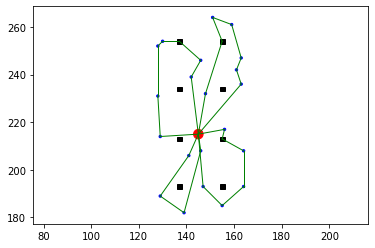

Run: 2 with random seed 2
End of run 2 with best solution quality 384.6780925829082 total evaluations: 750073.666538019


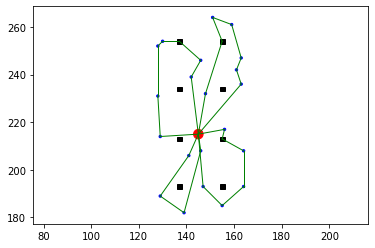

Run: 3 with random seed 3
End of run 3 with best solution quality 384.6780925829082 total evaluations: 750031.9998712111


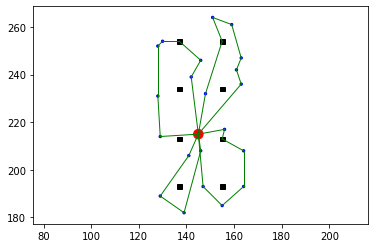

Run: 4 with random seed 4
End of run 4 with best solution quality 384.67809258290833 total evaluations: 750027.7332046373


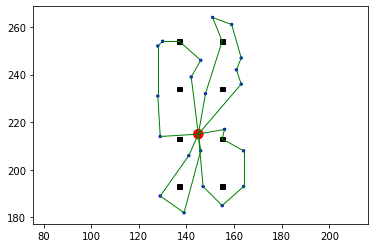

Run: 5 with random seed 5
End of run 5 with best solution quality 384.6780925829082 total evaluations: 750026.9998711894


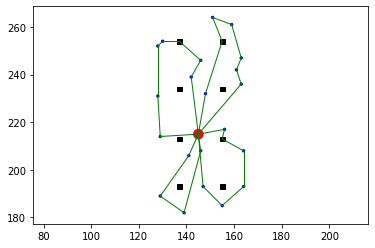

Run: 6 with random seed 6
End of run 6 with best solution quality 385.38932642516005 total evaluations: 750074.5332047709


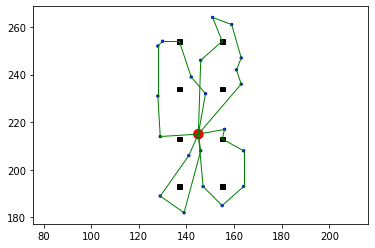

Run: 7 with random seed 7
End of run 7 with best solution quality 385.38932642516016 total evaluations: 750034.3332045084


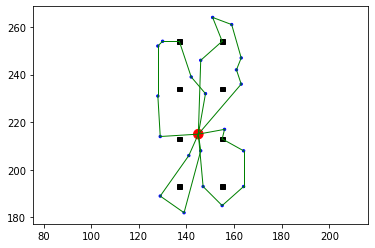

Run: 8 with random seed 8
End of run 8 with best solution quality 384.67809258290833 total evaluations: 750043.4665378745


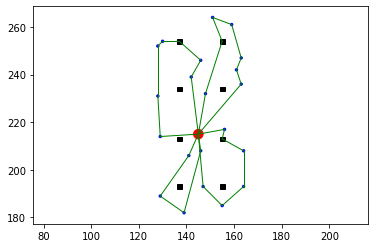

Run: 9 with random seed 9
End of run 9 with best solution quality 386.69243241261046 total evaluations: 750167.9332042569


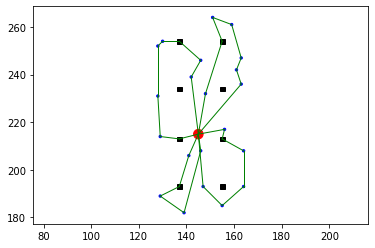

Run: 10 with random seed 10
End of run 10 with best solution quality 384.6780925829082 total evaluations: 750037.3332046861


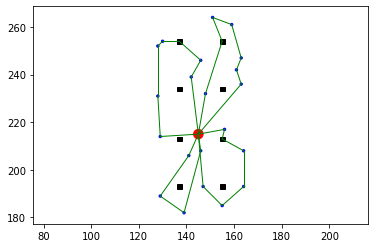

Run: 11 with random seed 11
End of run 11 with best solution quality 384.6780925829082 total evaluations: 750133.3998712314


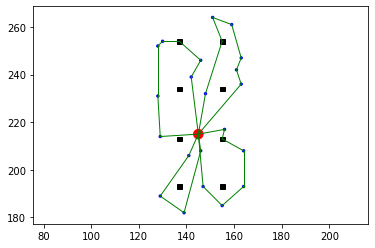

Run: 12 with random seed 12
End of run 12 with best solution quality 384.67809258290816 total evaluations: 750131.8665378835


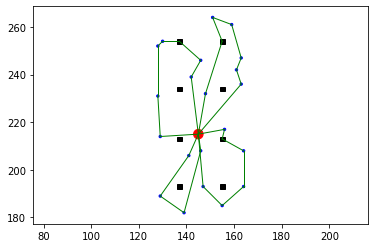

Run: 13 with random seed 13
End of run 13 with best solution quality 384.67809258290833 total evaluations: 750038.6665377859


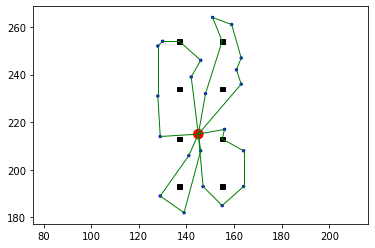

Run: 14 with random seed 14
End of run 14 with best solution quality 384.67809258290833 total evaluations: 750024.7998712355


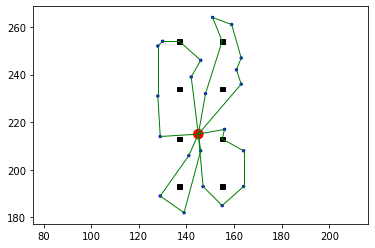

Run: 15 with random seed 15
End of run 15 with best solution quality 384.67809258290833 total evaluations: 750181.9332045988


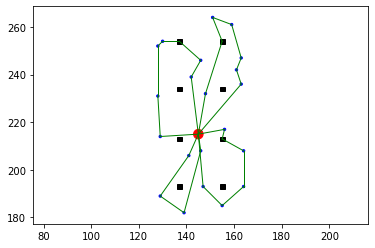

Run: 16 with random seed 16
End of run 16 with best solution quality 386.415182954958 total evaluations: 750129.5665375125


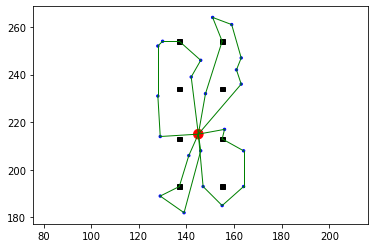

Run: 17 with random seed 17
End of run 17 with best solution quality 384.6780925829082 total evaluations: 750013.0665380197


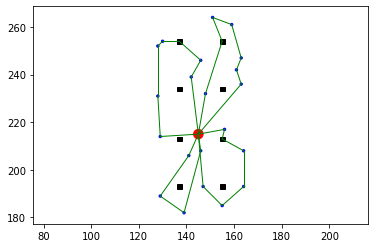

Run: 18 with random seed 18
End of run 18 with best solution quality 384.6780925829082 total evaluations: 750030.666537666


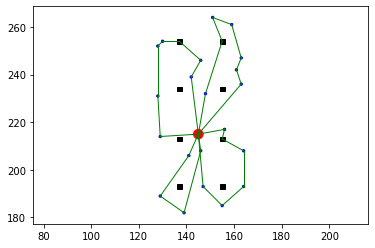

Run: 19 with random seed 19
End of run 19 with best solution quality 384.6780925829082 total evaluations: 750026.1332047543


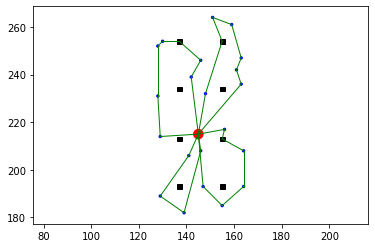

Run: 20 with random seed 20
End of run 20 with best solution quality 385.38932642516016 total evaluations: 750014.8665379306


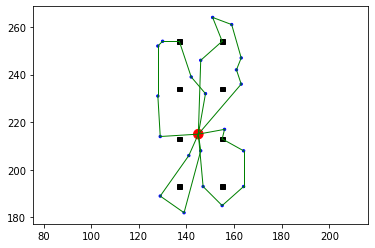

Running: .\evrp-benchmark-set\E-n23-k3.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 581.0703111531125 total evaluations: 800068.125


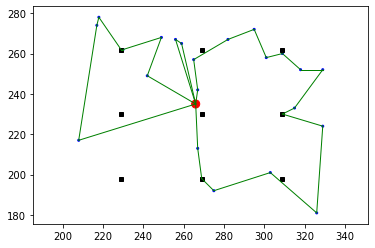

Run: 2 with random seed 2
End of run 2 with best solution quality 581.0703111531125 total evaluations: 800053.0625


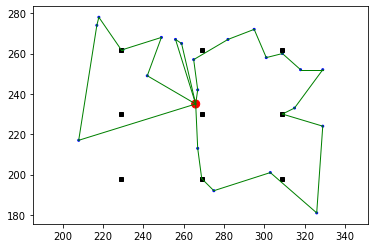

Run: 3 with random seed 3
End of run 3 with best solution quality 583.034312449397 total evaluations: 800091.15625


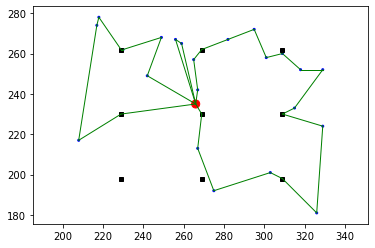

Run: 4 with random seed 4
End of run 4 with best solution quality 581.0703111531125 total evaluations: 800038.1875


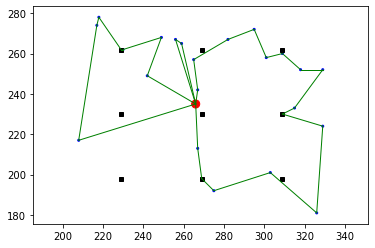

Run: 5 with random seed 5
End of run 5 with best solution quality 581.0703111531125 total evaluations: 800082.8125


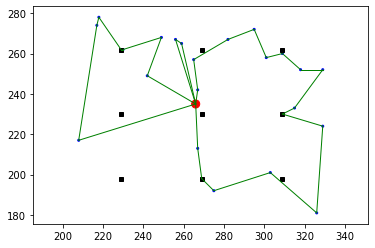

Run: 6 with random seed 6
End of run 6 with best solution quality 581.0703111531125 total evaluations: 800063.75


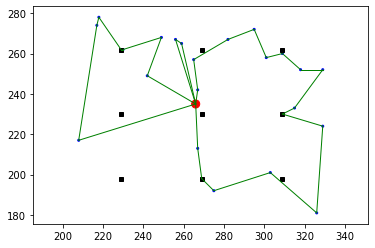

Run: 7 with random seed 7
End of run 7 with best solution quality 581.0703111531125 total evaluations: 800036.5


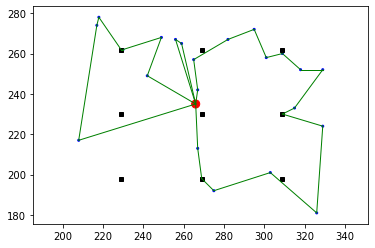

Run: 8 with random seed 8
End of run 8 with best solution quality 581.0703111531125 total evaluations: 800051.0625


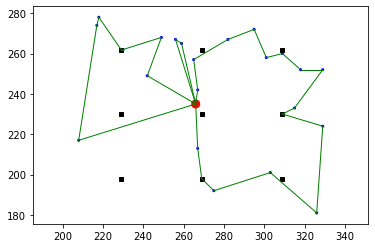

Run: 9 with random seed 9
End of run 9 with best solution quality 581.0703111531125 total evaluations: 800027.9375


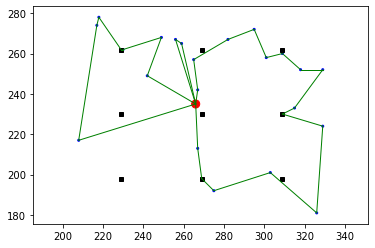

Run: 10 with random seed 10
End of run 10 with best solution quality 581.0703111531127 total evaluations: 800124.625


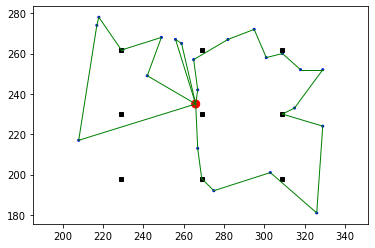

Run: 11 with random seed 11
End of run 11 with best solution quality 581.0703111531125 total evaluations: 800010.625


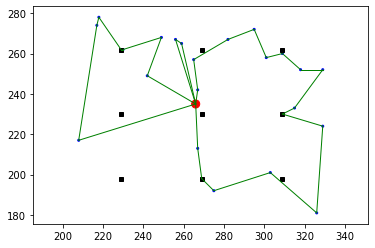

Run: 12 with random seed 12
End of run 12 with best solution quality 581.0703111531125 total evaluations: 800021.125


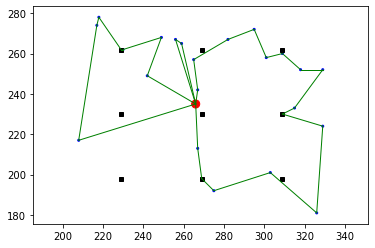

Run: 13 with random seed 13
End of run 13 with best solution quality 581.0703111531125 total evaluations: 800035.75


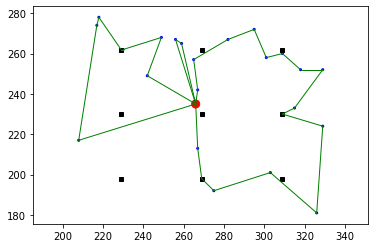

Run: 14 with random seed 14
End of run 14 with best solution quality 581.0703111531125 total evaluations: 800095.25


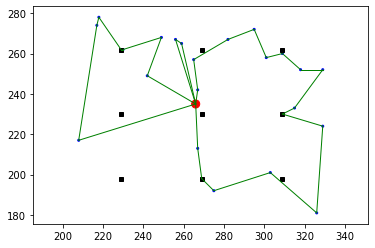

Run: 15 with random seed 15
End of run 15 with best solution quality 581.0703111531125 total evaluations: 800017.75


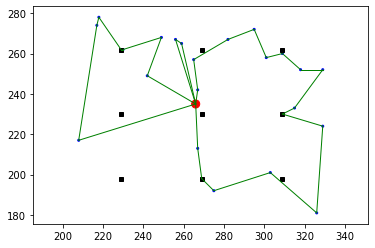

Run: 16 with random seed 16
End of run 16 with best solution quality 581.0703111531125 total evaluations: 800093.9375


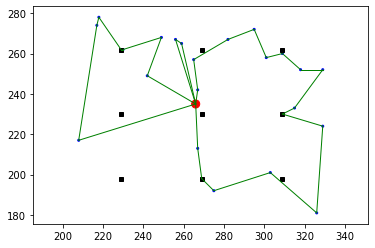

Run: 17 with random seed 17
End of run 17 with best solution quality 581.0703111531125 total evaluations: 800039.0


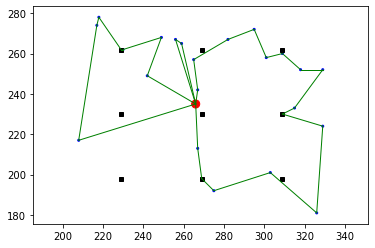

Run: 18 with random seed 18
End of run 18 with best solution quality 581.0703111531125 total evaluations: 800111.1875


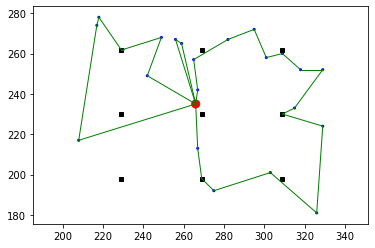

Run: 19 with random seed 19
End of run 19 with best solution quality 582.1088333314732 total evaluations: 800011.375


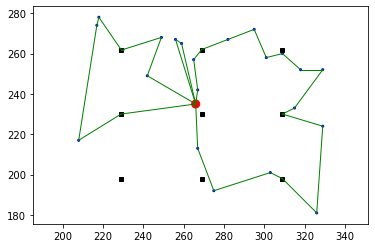

Run: 20 with random seed 20
End of run 20 with best solution quality 573.252964425709 total evaluations: 800100.84375


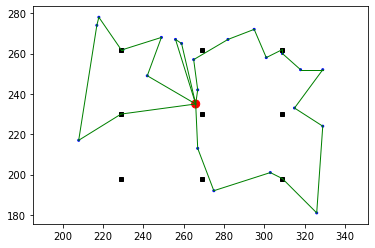

Running: .\evrp-benchmark-set\E-n30-k3.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 527.6591130892525 total evaluations: 900072.1105521325


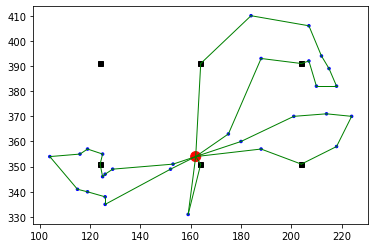

Run: 2 with random seed 2
End of run 2 with best solution quality 527.6591130892525 total evaluations: 900149.0549954603


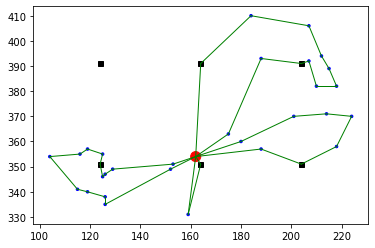

Run: 3 with random seed 3
End of run 3 with best solution quality 510.4966677405502 total evaluations: 900066.2494433975


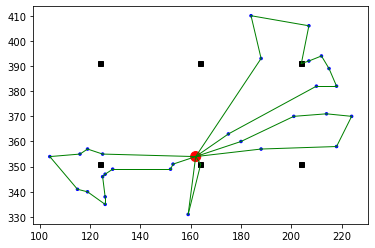

Run: 4 with random seed 4
End of run 4 with best solution quality 523.9090394016603 total evaluations: 900033.8327758602


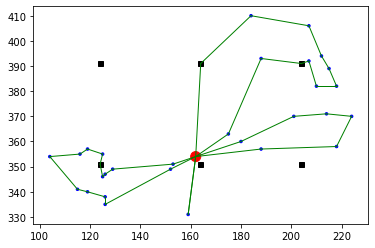

Run: 5 with random seed 5
End of run 5 with best solution quality 527.6591130892524 total evaluations: 900017.2216623888


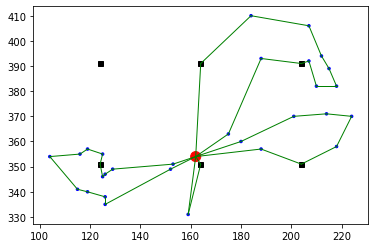

Run: 6 with random seed 6
End of run 6 with best solution quality 524.9352917957261 total evaluations: 900048.527220547


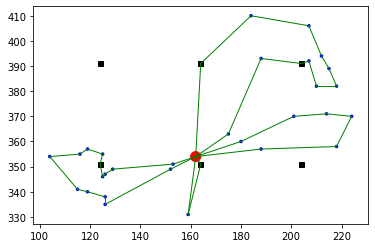

Run: 7 with random seed 7
End of run 7 with best solution quality 526.6328606951867 total evaluations: 900009.5272206871


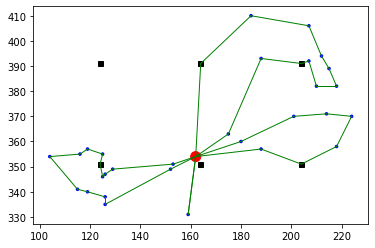

Run: 8 with random seed 8
End of run 8 with best solution quality 527.6591130892525 total evaluations: 900109.3327753705


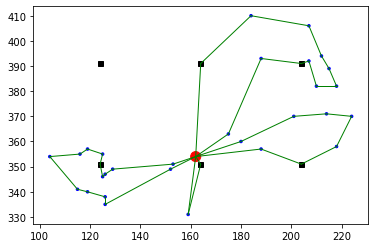

Run: 9 with random seed 9
End of run 9 with best solution quality 526.6328606951867 total evaluations: 900116.9161087723


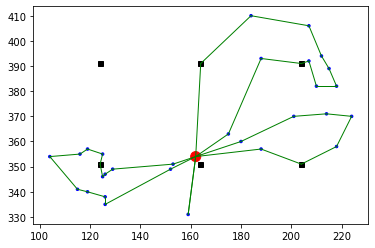

Run: 10 with random seed 10
End of run 10 with best solution quality 526.6328606951865 total evaluations: 900063.1383312119


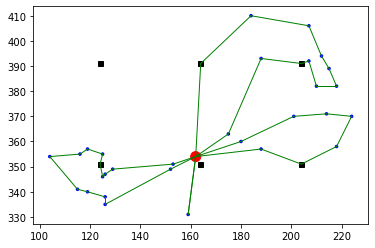

Run: 11 with random seed 11
End of run 11 with best solution quality 527.6591130892524 total evaluations: 900191.0549978439


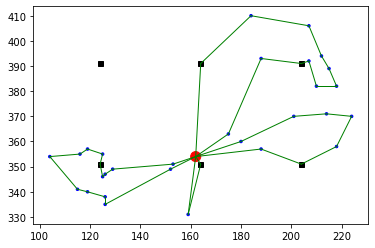

Run: 12 with random seed 12
End of run 12 with best solution quality 527.6591130892525 total evaluations: 900044.6661072996


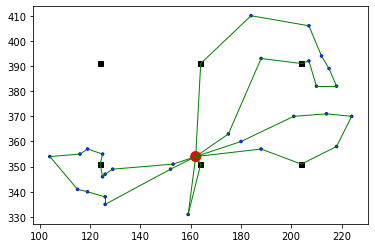

Run: 13 with random seed 13
End of run 13 with best solution quality 526.6328606951867 total evaluations: 900006.0827751104


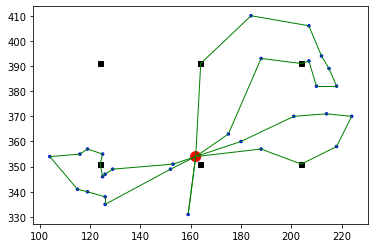

Run: 14 with random seed 14
End of run 14 with best solution quality 527.6591130892524 total evaluations: 900077.3327756659


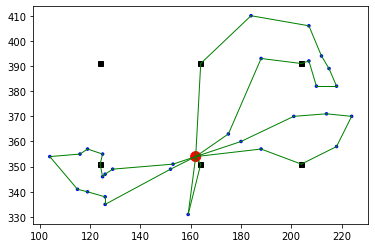

Run: 15 with random seed 15
End of run 15 with best solution quality 527.6591130892525 total evaluations: 900009.1105526934


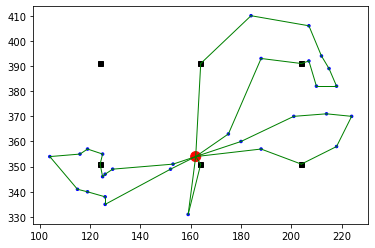

Run: 16 with random seed 16
End of run 16 with best solution quality 520.3242040087263 total evaluations: 900141.8327753828


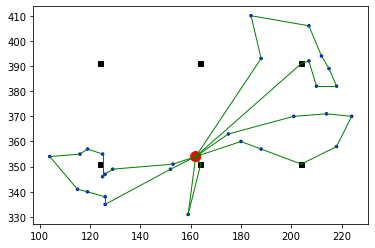

Run: 17 with random seed 17
End of run 17 with best solution quality 527.6591130892525 total evaluations: 900193.7216629608


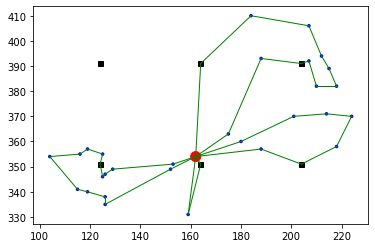

Run: 18 with random seed 18
End of run 18 with best solution quality 527.6591130892525 total evaluations: 900065.1105526458


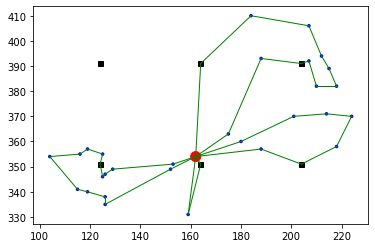

Run: 19 with random seed 19
End of run 19 with best solution quality 527.6591130892525 total evaluations: 900044.5549983019


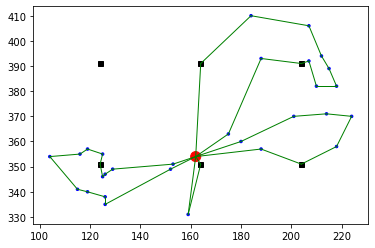

Run: 20 with random seed 20
End of run 20 with best solution quality 527.6591130892525 total evaluations: 900050.9438868073


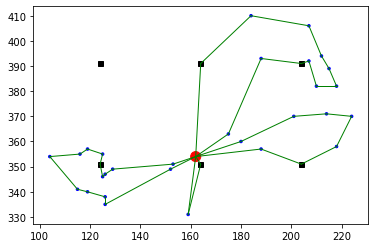

Running: .\evrp-benchmark-set\E-n33-k4.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 845.0452967615427 total evaluations: 975172.7945318404


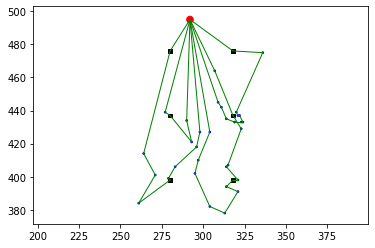

Run: 2 with random seed 2
End of run 2 with best solution quality 849.8820330933742 total evaluations: 975071.2560709007


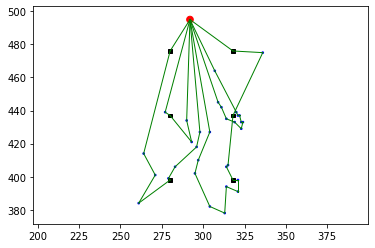

Run: 3 with random seed 3
End of run 3 with best solution quality 845.4694506287221 total evaluations: 975150.5381216352


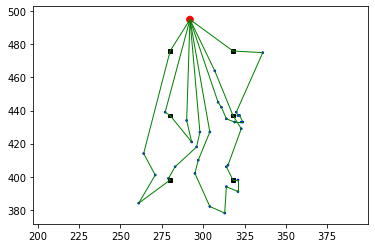

Run: 4 with random seed 4
End of run 4 with best solution quality 849.1313637564799 total evaluations: 975062.2817120733


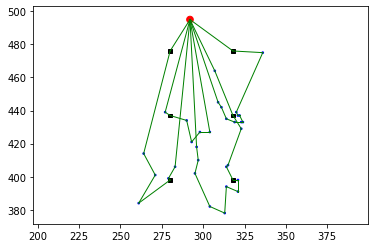

Run: 5 with random seed 5
End of run 5 with best solution quality 845.4694506287224 total evaluations: 975026.589404078


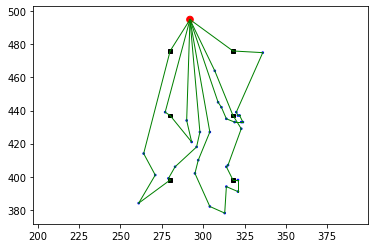

Run: 6 with random seed 6
End of run 6 with best solution quality 845.4694506287221 total evaluations: 975012.4868405525


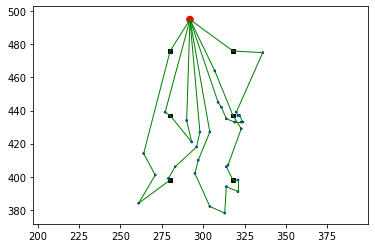

Run: 7 with random seed 7
End of run 7 with best solution quality 849.9360079712768 total evaluations: 975257.4611984666


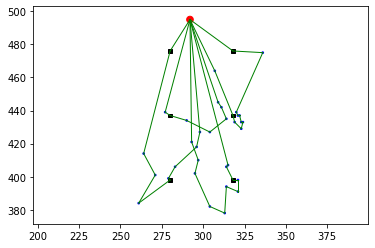

Run: 8 with random seed 8
End of run 8 with best solution quality 845.4694506287226 total evaluations: 975107.3073526727


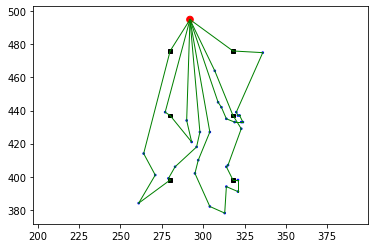

Run: 9 with random seed 9
End of run 9 with best solution quality 842.0223905420469 total evaluations: 975137.8458154501


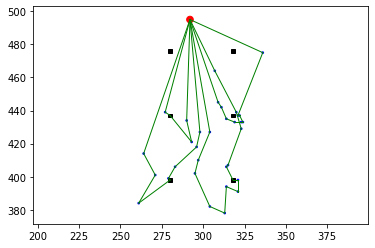

Run: 10 with random seed 10
End of run 10 with best solution quality 848.5745496057095 total evaluations: 975283.358635204


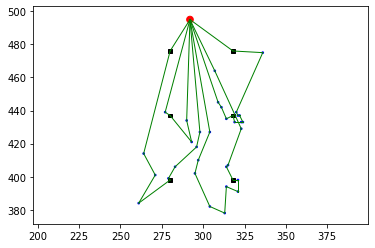

Run: 11 with random seed 11
End of run 11 with best solution quality 845.4694506287221 total evaluations: 975088.7945327273


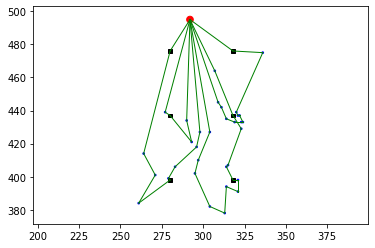

Run: 12 with random seed 12
End of run 12 with best solution quality 845.0452967615423 total evaluations: 975014.69196869


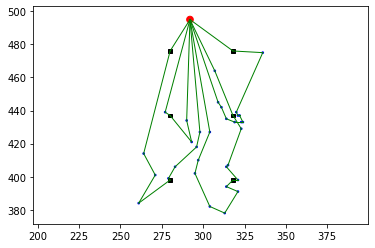

Run: 13 with random seed 13
End of run 13 with best solution quality 850.4984731291868 total evaluations: 975171.6150453088


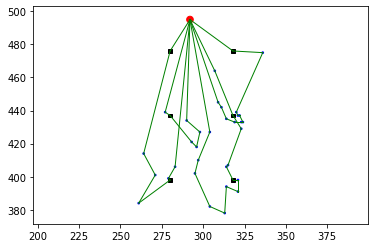

Run: 14 with random seed 14
End of run 14 with best solution quality 845.0452967615425 total evaluations: 975110.4868402098


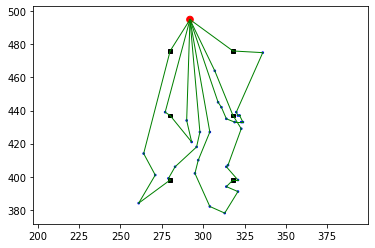

Run: 15 with random seed 15
End of run 15 with best solution quality 845.0452967615422 total evaluations: 975059.3586342757


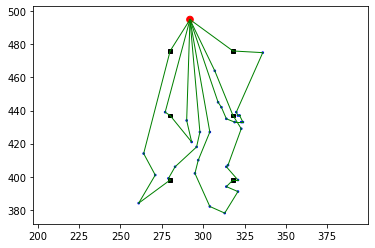

Run: 16 with random seed 16
End of run 16 with best solution quality 850.2783990375742 total evaluations: 975090.2817120005


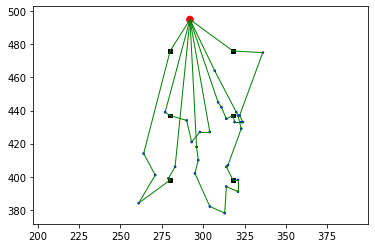

Run: 17 with random seed 17
End of run 17 with best solution quality 846.6764927465586 total evaluations: 975034.0509433268


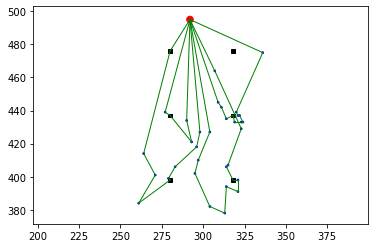

Run: 18 with random seed 18
End of run 18 with best solution quality 847.2696773973313 total evaluations: 975122.9996592887


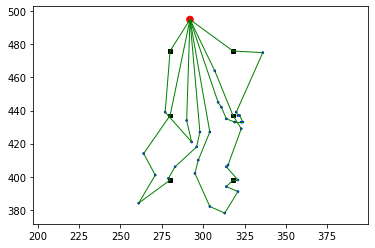

Run: 19 with random seed 19
End of run 19 with best solution quality 846.1588275532373 total evaluations: 975053.0253011578


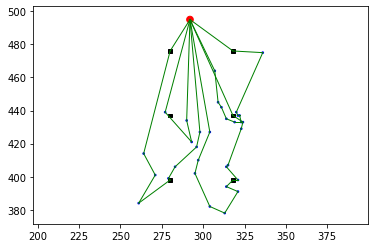

Run: 20 with random seed 20
End of run 20 with best solution quality 849.1313637564801 total evaluations: 975111.7176096933


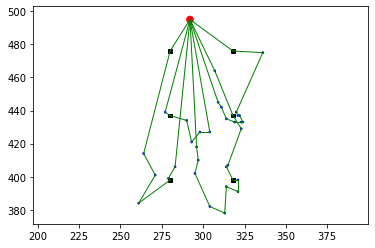

Running: .\evrp-benchmark-set\E-n51-k5.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 562.7041943097129 total evaluations: 1500009.5999284221


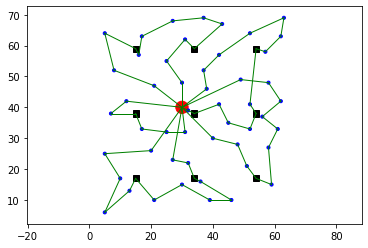

Run: 2 with random seed 2
End of run 2 with best solution quality 541.7864058006979 total evaluations: 1500233.9665931875


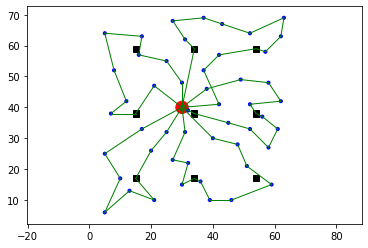

Run: 3 with random seed 3
End of run 3 with best solution quality 536.8746038653283 total evaluations: 1500241.7332592297


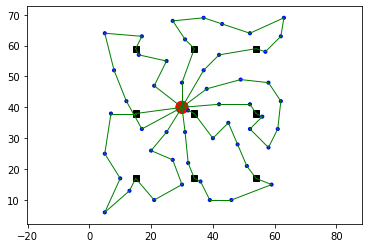

Run: 4 with random seed 4
End of run 4 with best solution quality 557.7726744115927 total evaluations: 1500224.1832639684


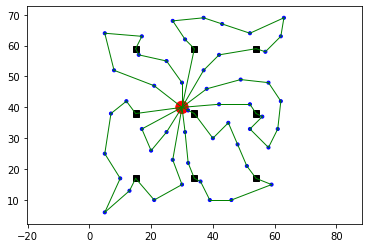

Run: 5 with random seed 5
End of run 5 with best solution quality 541.6906957424624 total evaluations: 1500150.366594209


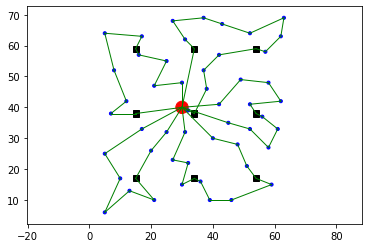

Run: 6 with random seed 6
End of run 6 with best solution quality 537.9469050864811 total evaluations: 1500194.6665945868


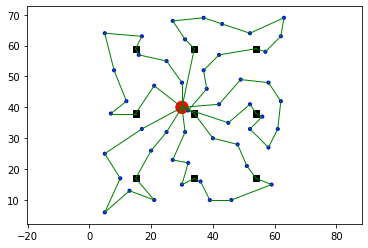

Run: 7 with random seed 7
End of run 7 with best solution quality 559.9652530156835 total evaluations: 1500115.6665931197


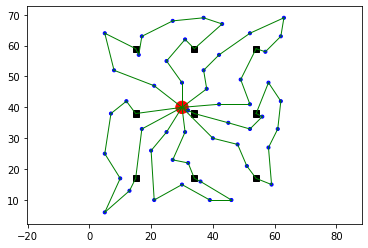

Run: 8 with random seed 8
End of run 8 with best solution quality 541.1438845371397 total evaluations: 1500206.4332592858


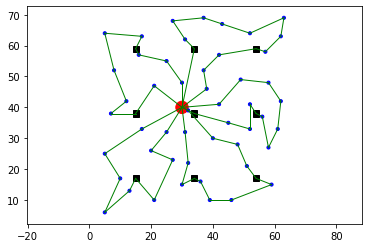

Run: 9 with random seed 9
End of run 9 with best solution quality 539.3790260883301 total evaluations: 1500182.1665931435


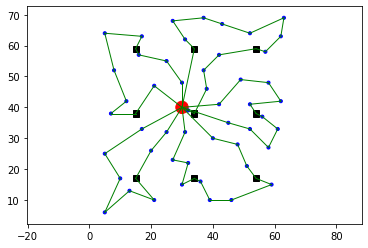

Run: 10 with random seed 10
End of run 10 with best solution quality 537.7482309893928 total evaluations: 1500015.4332596117


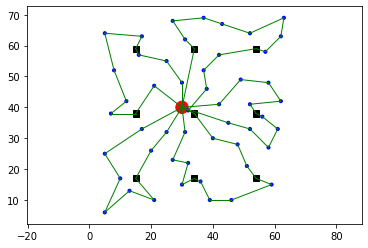

Run: 11 with random seed 11
End of run 11 with best solution quality 536.8746038653283 total evaluations: 1500276.6999272234


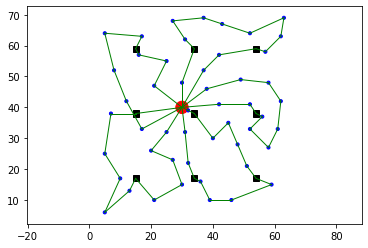

Run: 12 with random seed 12
End of run 12 with best solution quality 542.7970120100337 total evaluations: 1500199.0999292878


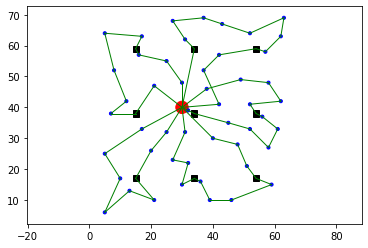

Run: 13 with random seed 13
End of run 13 with best solution quality 541.9333015780282 total evaluations: 1500289.2332618616


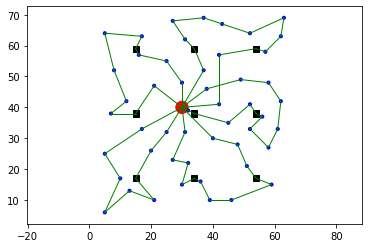

Run: 14 with random seed 14
End of run 14 with best solution quality 558.0815546089154 total evaluations: 1500222.6999280115


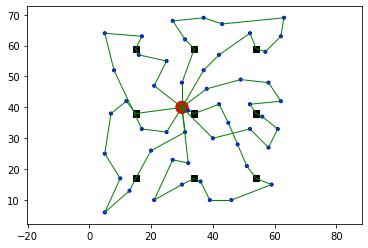

Run: 15 with random seed 15
End of run 15 with best solution quality 558.7328723430014 total evaluations: 1500276.666590701


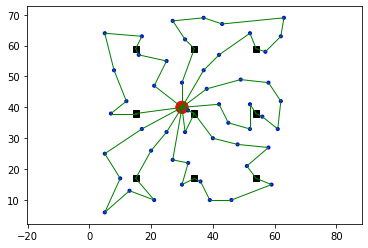

Run: 16 with random seed 16
End of run 16 with best solution quality 563.3324902275367 total evaluations: 1500013.0499289567


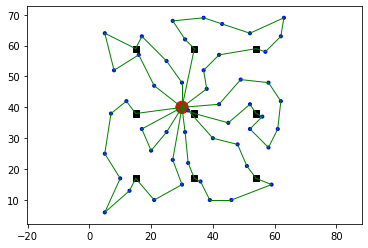

Run: 17 with random seed 17
End of run 17 with best solution quality 543.5065845519727 total evaluations: 1500046.299928402


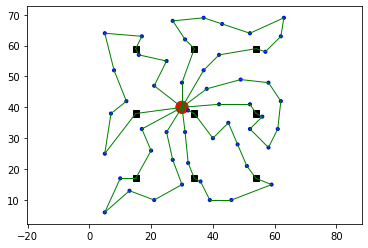

Run: 18 with random seed 18
End of run 18 with best solution quality 545.7370534525571 total evaluations: 1500075.599929897


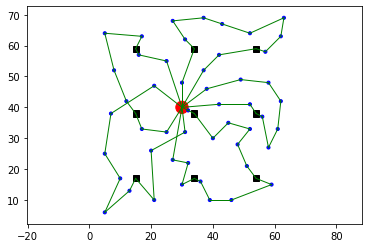

Run: 19 with random seed 19
End of run 19 with best solution quality 539.3790260883302 total evaluations: 1500366.7999240349


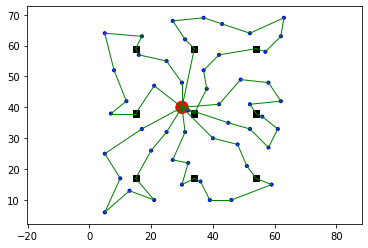

Run: 20 with random seed 20
End of run 20 with best solution quality 546.3447653367717 total evaluations: 1500288.5499275154


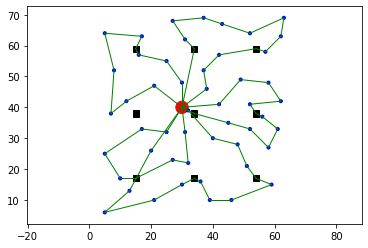

Running: .\evrp-benchmark-set\E-n76-k7.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 747.2887130673054 total evaluations: 2125524.682428599


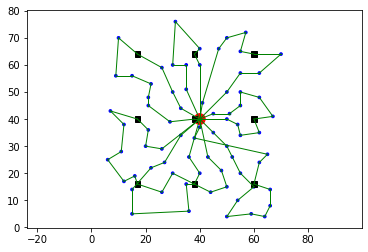

Run: 2 with random seed 2
End of run 2 with best solution quality 729.6834841722563 total evaluations: 2125027.600066383


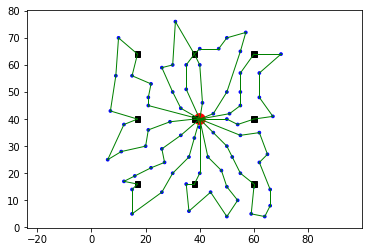

Run: 3 with random seed 3
End of run 3 with best solution quality 708.0334166369383 total evaluations: 2125512.6941944393


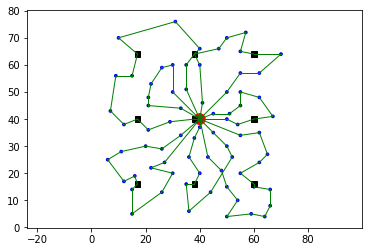

Run: 4 with random seed 4
End of run 4 with best solution quality 723.7296889674959 total evaluations: 2125174.576536097


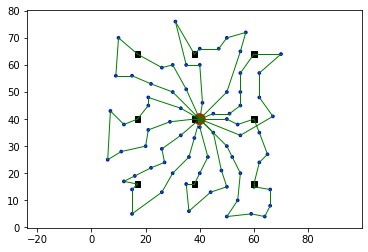

Run: 5 with random seed 5
End of run 5 with best solution quality 720.2326187019551 total evaluations: 2125526.8941931776


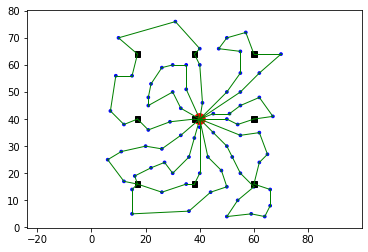

Run: 6 with random seed 6
End of run 6 with best solution quality 749.2870132699899 total evaluations: 2125404.717718108


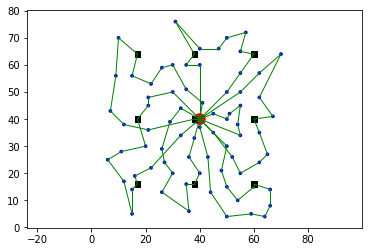

Run: 7 with random seed 7
End of run 7 with best solution quality 759.7098876492162 total evaluations: 2125794.4353755987


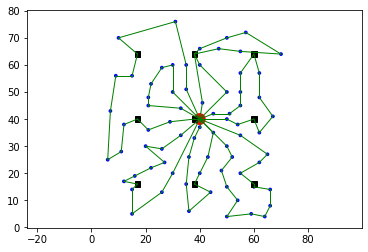

Run: 8 with random seed 8
End of run 8 with best solution quality 734.6065534854589 total evaluations: 2125216.717717184


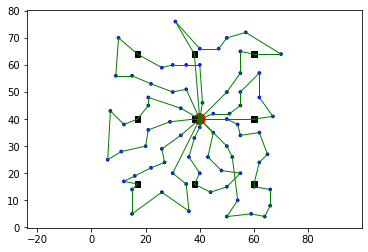

Run: 9 with random seed 9
End of run 9 with best solution quality 723.1161457567052 total evaluations: 2125408.8236039993


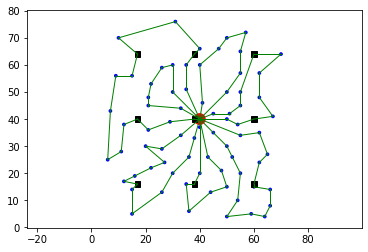

Run: 10 with random seed 10
End of run 10 with best solution quality 729.0535149154923 total evaluations: 2125277.5530130835


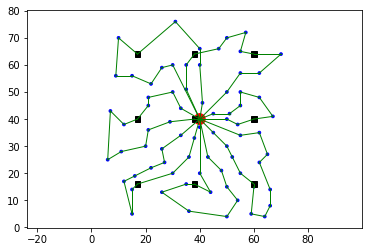

Run: 11 with random seed 11
End of run 11 with best solution quality 723.1909892788929 total evaluations: 2125019.0706526064


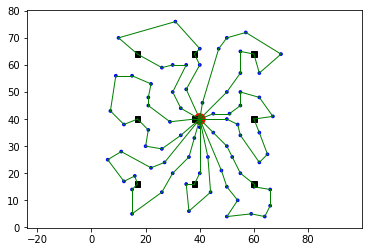

Run: 12 with random seed 12
End of run 12 with best solution quality 715.9319453984903 total evaluations: 2125046.623594652


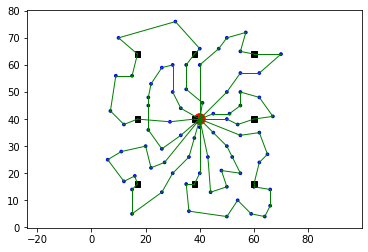

Run: 13 with random seed 13
End of run 13 with best solution quality 740.1878712929126 total evaluations: 2125274.870657252


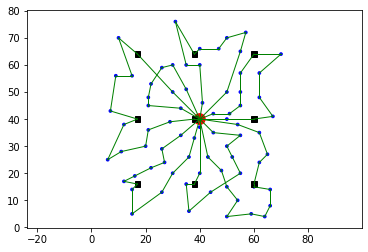

Run: 14 with random seed 14
End of run 14 with best solution quality 757.4838614742187 total evaluations: 2125090.470656802


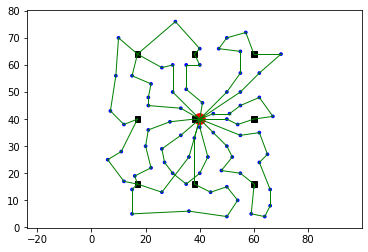

Run: 15 with random seed 15
End of run 15 with best solution quality 717.1439028980826 total evaluations: 2125385.553013517


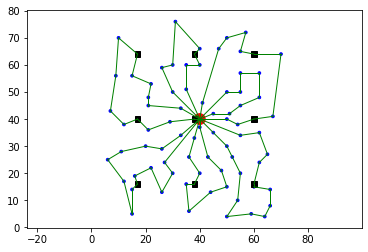

Run: 16 with random seed 16
End of run 16 with best solution quality 717.812495824233 total evaluations: 2125488.953017208


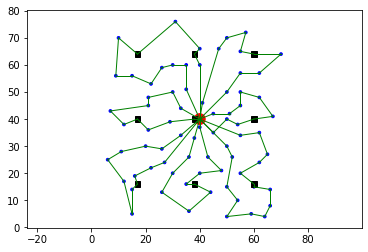

Run: 17 with random seed 17
End of run 17 with best solution quality 721.626621595776 total evaluations: 2125225.3765397635


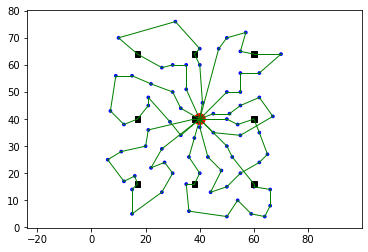

Run: 18 with random seed 18
End of run 18 with best solution quality 732.2251461197901 total evaluations: 2125189.4941879706


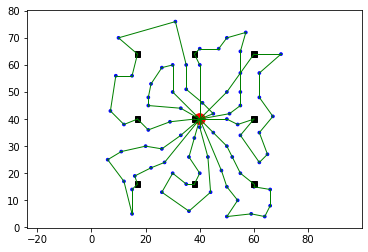

Run: 19 with random seed 19
End of run 19 with best solution quality 734.6169869398439 total evaluations: 2125266.6235999814


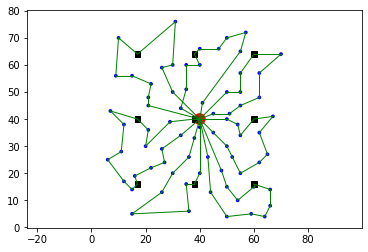

Run: 20 with random seed 20
End of run 20 with best solution quality 722.6553492055821 total evaluations: 2125025.8941834816


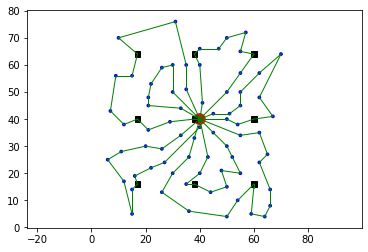

Running: .\evrp-benchmark-set\E-n101-k8.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 872.1472913136676 total evaluations: 2750766.93977903


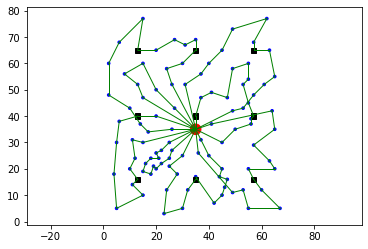

Run: 2 with random seed 2
End of run 2 with best solution quality 869.6607559735401 total evaluations: 2750015.776119249


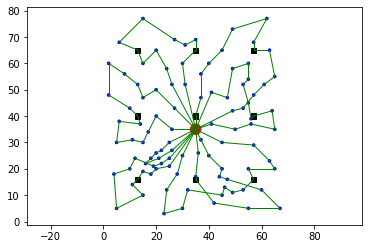

Run: 3 with random seed 3
End of run 3 with best solution quality 914.3137622958207 total evaluations: 2750270.5761111244


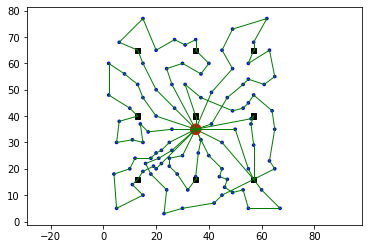

Run: 4 with random seed 4
End of run 4 with best solution quality 893.2443954227995 total evaluations: 2750611.4215826546


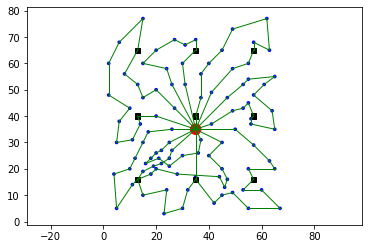

Run: 5 with random seed 5
End of run 5 with best solution quality 879.7661430938224 total evaluations: 2750387.948840151


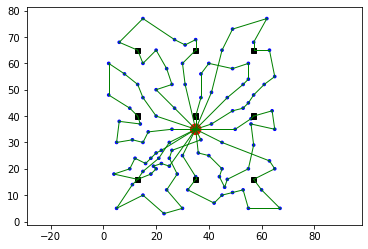

Run: 6 with random seed 6
End of run 6 with best solution quality 892.5568523929347 total evaluations: 2750320.4215762466


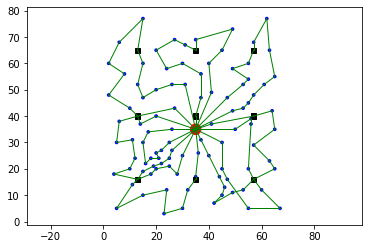

Run: 7 with random seed 7
End of run 7 with best solution quality 893.6574796419744 total evaluations: 2750076.3943128847


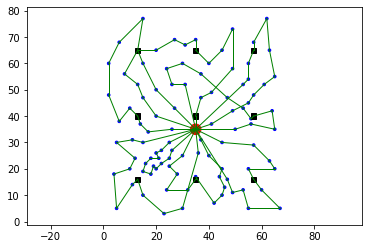

Run: 8 with random seed 8
End of run 8 with best solution quality 881.6331160266881 total evaluations: 2750188.16703241


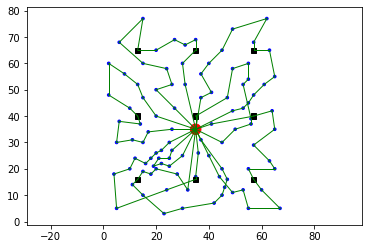

Run: 9 with random seed 9
End of run 9 with best solution quality 862.0724651737311 total evaluations: 2750113.1488532685


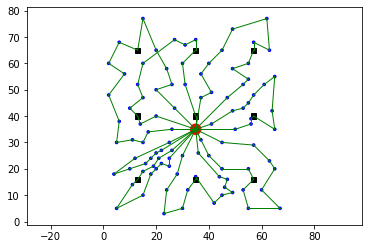

Run: 10 with random seed 10
End of run 10 with best solution quality 891.6778161731996 total evaluations: 2750924.994357137


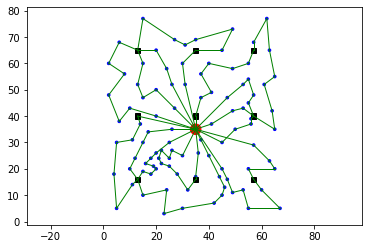

Run: 11 with random seed 11
End of run 11 with best solution quality 867.4724665201932 total evaluations: 2750682.321595301


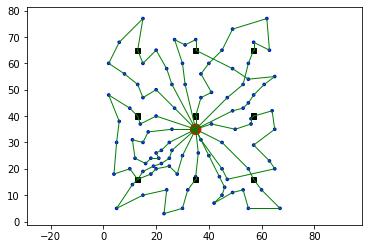

Run: 12 with random seed 12
End of run 12 with best solution quality 878.5937877684925 total evaluations: 2750410.2034112015


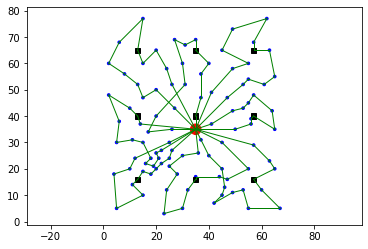

Run: 13 with random seed 13
End of run 13 with best solution quality 908.4778809807965 total evaluations: 2750778.457965372


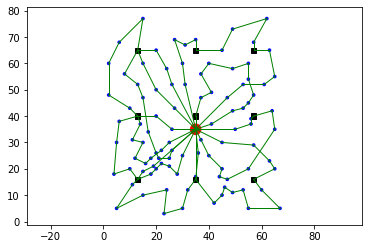

Run: 14 with random seed 14
End of run 14 with best solution quality 869.7996239730692 total evaluations: 2750335.103415405


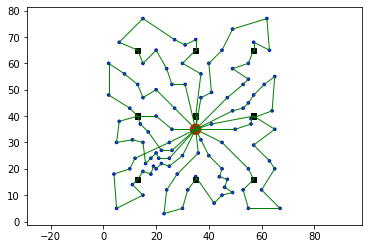

Run: 15 with random seed 15
End of run 15 with best solution quality 880.634627994319 total evaluations: 2750132.312506636


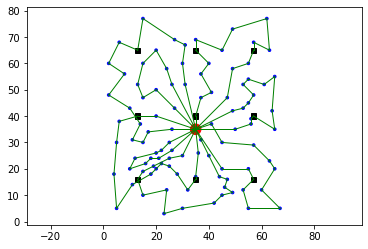

Run: 16 with random seed 16
End of run 16 with best solution quality 884.4731190042438 total evaluations: 2750418.639753526


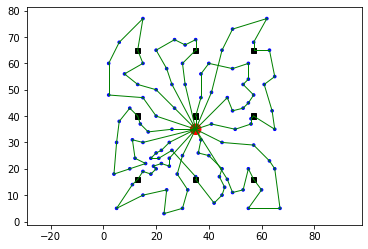

Run: 17 with random seed 17
End of run 17 with best solution quality 873.4358557956143 total evaluations: 2750808.676151015


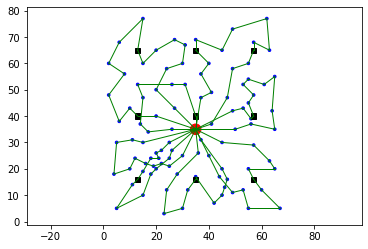

Run: 18 with random seed 18
End of run 18 with best solution quality 919.950036510716 total evaluations: 2751863.858005706


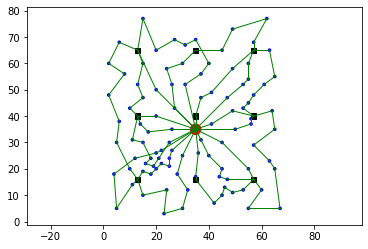

Run: 19 with random seed 19
End of run 19 with best solution quality 857.0986756986414 total evaluations: 2750203.767042862


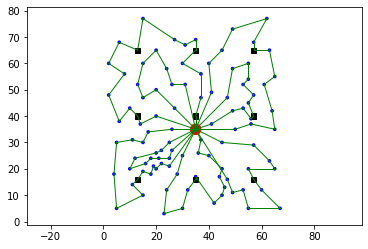

Run: 20 with random seed 20
End of run 20 with best solution quality 926.7365760096505 total evaluations: 2751263.2670777338


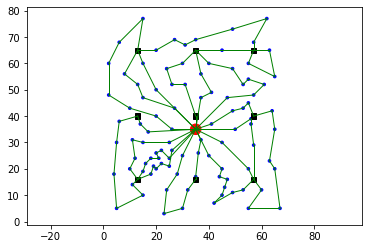

Running: .\evrp-benchmark-set\X-n143-k7.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 17655.03649917691 total evaluations: 3675044.4694770155


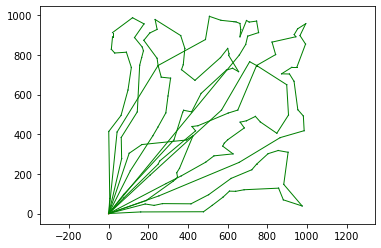

Run: 2 with random seed 2
End of run 2 with best solution quality 18103.04141187175 total evaluations: 3675112.0272857877


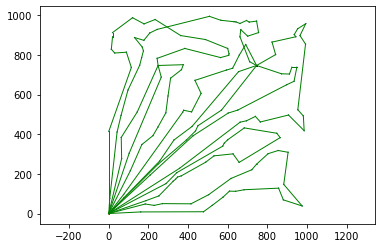

Run: 3 with random seed 3
End of run 3 with best solution quality 17372.555327906623 total evaluations: 3675186.564729909


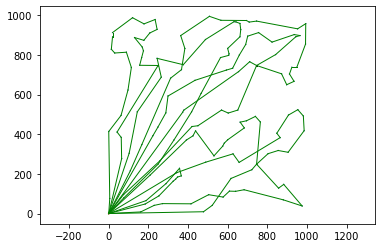

Run: 4 with random seed 4
End of run 4 with best solution quality 17499.003136075557 total evaluations: 3675177.129340019


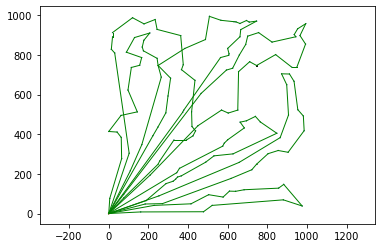

Run: 5 with random seed 5
End of run 5 with best solution quality 17867.02016392209 total evaluations: 3675547.7891987595


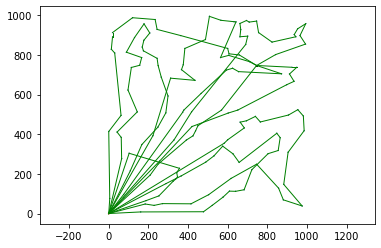

Run: 6 with random seed 6
End of run 6 with best solution quality 17599.981843345086 total evaluations: 3675346.755169908


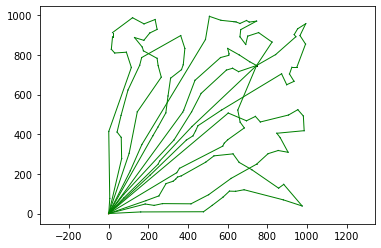

Run: 7 with random seed 7
End of run 7 with best solution quality 17609.66139077275 total evaluations: 3675450.8708235333


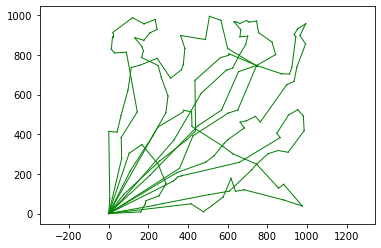

Run: 8 with random seed 8
End of run 8 with best solution quality 17465.48902621982 total evaluations: 3675428.898046519


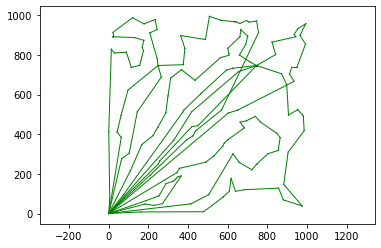

Run: 9 with random seed 9
End of run 9 with best solution quality 18058.113146597905 total evaluations: 3675869.9456712715


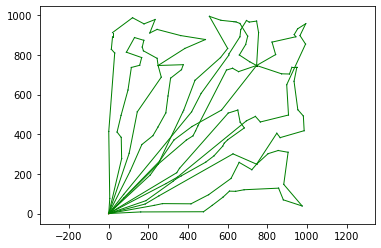

Run: 10 with random seed 10
End of run 10 with best solution quality 17842.201120093843 total evaluations: 3675061.17693631


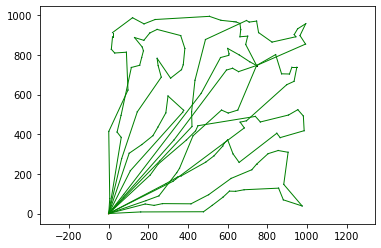

Run: 11 with random seed 11
End of run 11 with best solution quality 17167.20264512483 total evaluations: 3675264.6191649726


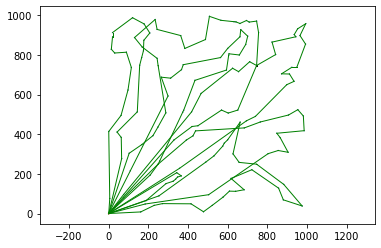

Run: 12 with random seed 12
End of run 12 with best solution quality 17466.791021543984 total evaluations: 3675983.4150251043


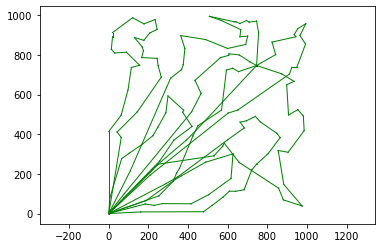

Run: 13 with random seed 13
End of run 13 with best solution quality 17671.76284945583 total evaluations: 3675298.7143974323


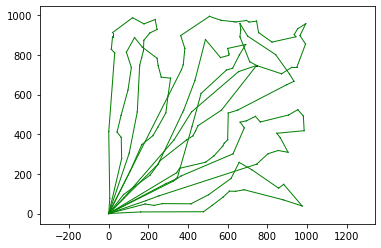

Run: 14 with random seed 14
End of run 14 with best solution quality 17695.0341181413 total evaluations: 3675189.347024067


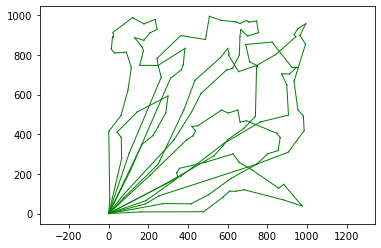

Run: 15 with random seed 15
End of run 15 with best solution quality 17742.754245594577 total evaluations: 3675024.728001273


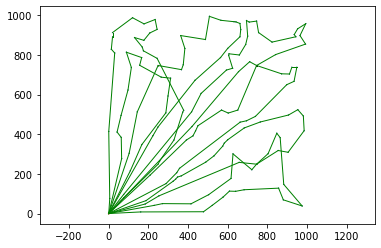

Run: 16 with random seed 16
End of run 16 with best solution quality 17372.670373798126 total evaluations: 3675829.190549489


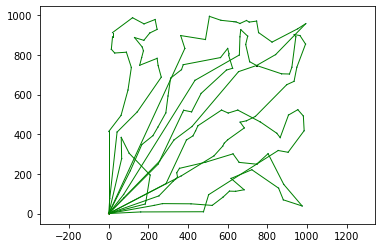

Run: 17 with random seed 17
End of run 17 with best solution quality 17294.788602754885 total evaluations: 3675597.4694403443


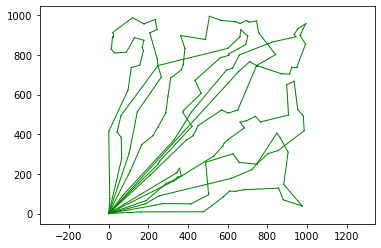

Run: 18 with random seed 18
End of run 18 with best solution quality 17028.888861222327 total evaluations: 3675047.442280777


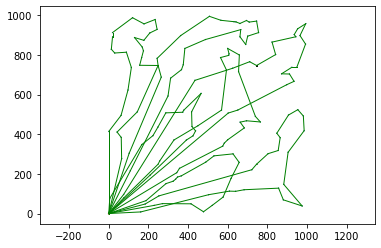

Run: 19 with random seed 19
End of run 19 with best solution quality 17308.299269999978 total evaluations: 3675296.3538226318


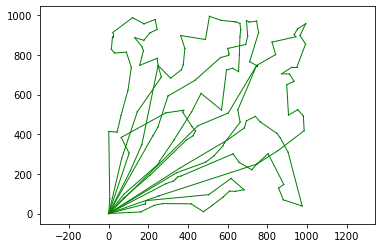

Run: 20 with random seed 20
End of run 20 with best solution quality 17386.601064723152 total evaluations: 3675194.877619535


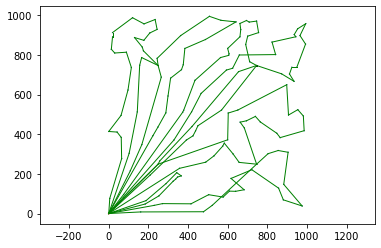

Running: .\evrp-benchmark-set\X-n214-k11.evrp
Run: 1 with random seed 1
End of run 1 with best solution quality 12341.044225343014 total evaluations: 5575848.812533297


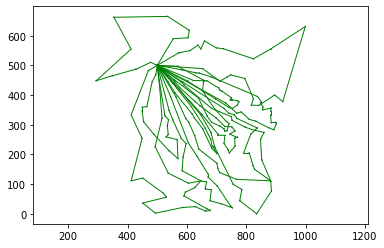

Run: 2 with random seed 2
End of run 2 with best solution quality 12863.412956941893 total evaluations: 5575013.548103869


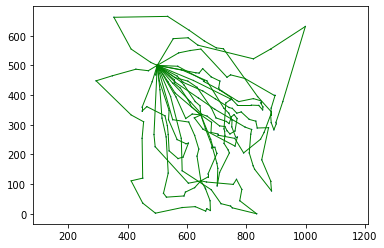

Run: 3 with random seed 3
End of run 3 with best solution quality 12176.519455135214 total evaluations: 5575083.305665874


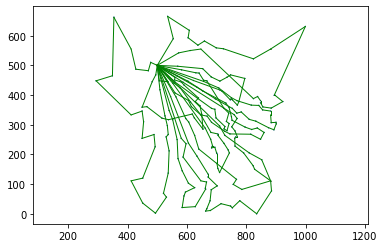

Run: 4 with random seed 4
End of run 4 with best solution quality 12796.527964733992 total evaluations: 5575066.265587773


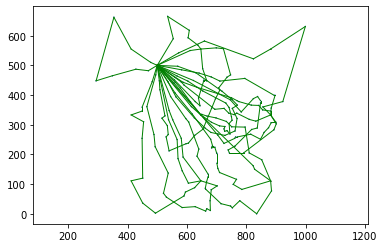

Run: 5 with random seed 5
End of run 5 with best solution quality 12264.01948267997 total evaluations: 5575050.655459786


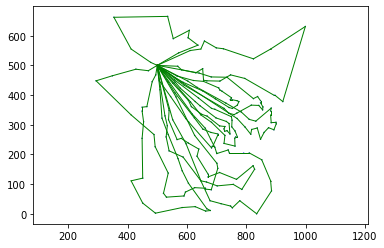

Run: 6 with random seed 6
End of run 6 with best solution quality 12714.842541903416 total evaluations: 5576247.646698469


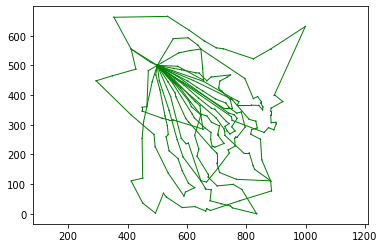

Run: 7 with random seed 7
End of run 7 with best solution quality 12498.157171260134 total evaluations: 5576082.341696838


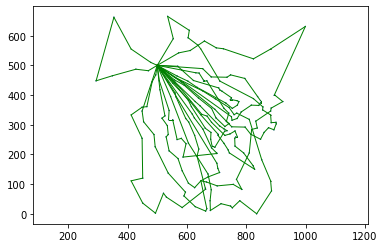

Run: 8 with random seed 8
End of run 8 with best solution quality 12287.421325012232 total evaluations: 5575071.153238924


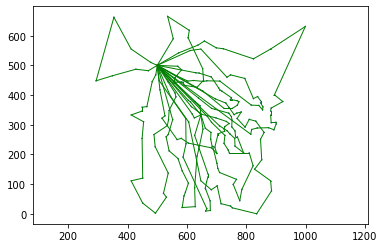

Run: 9 with random seed 9
End of run 9 with best solution quality 12177.052642026498 total evaluations: 5575283.117353754


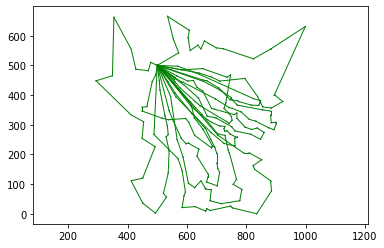

Run: 10 with random seed 10
End of run 10 with best solution quality 12360.397244384929 total evaluations: 5575798.0187985115


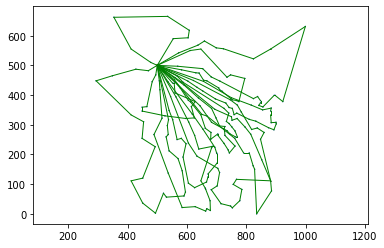

Run: 11 with random seed 11
End of run 11 with best solution quality 12212.904790593799 total evaluations: 5575489.758653717


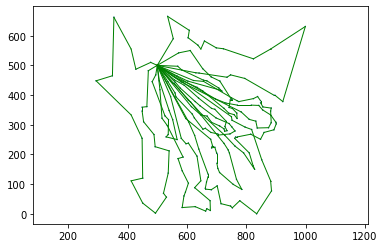

Run: 12 with random seed 12
End of run 12 with best solution quality 12776.830006802766 total evaluations: 5575229.749778149


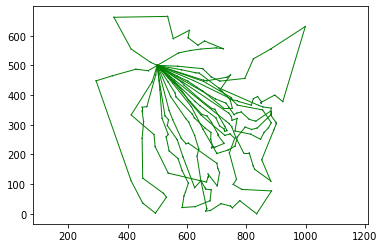

Run: 13 with random seed 13
End of run 13 with best solution quality 12400.88577695063 total evaluations: 5575991.552346845


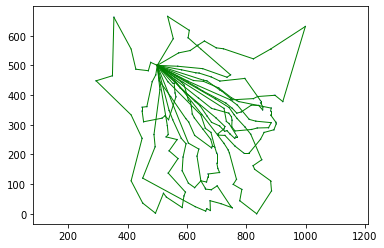

Run: 14 with random seed 14
End of run 14 with best solution quality 12744.940267457332 total evaluations: 5575572.736448152


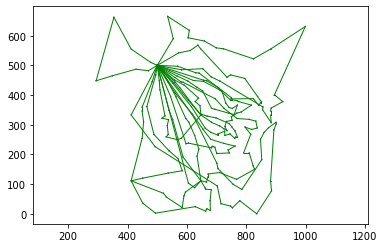

Run: 15 with random seed 15
End of run 15 with best solution quality 12153.176385127108 total evaluations: 5575017.399891004


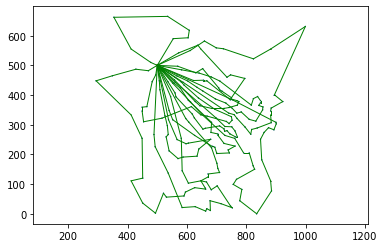

Run: 16 with random seed 16
End of run 16 with best solution quality 12278.495632913511 total evaluations: 5575526.5388965495


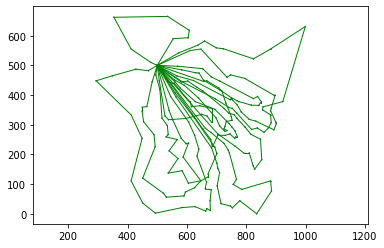

Run: 17 with random seed 17
End of run 17 with best solution quality 12680.965802326431 total evaluations: 5576176.462946483


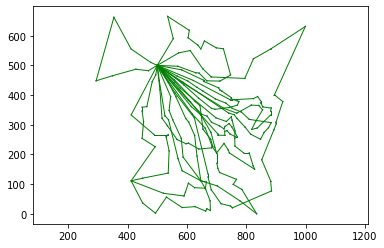

Run: 18 with random seed 18
End of run 18 with best solution quality 12301.275706665243 total evaluations: 5575542.22494146


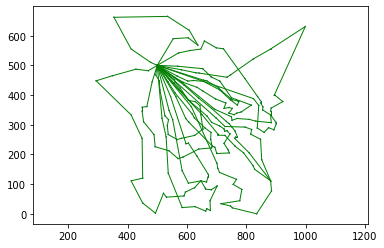

Run: 19 with random seed 19
End of run 19 with best solution quality 12987.338563152452 total evaluations: 5575098.139846637


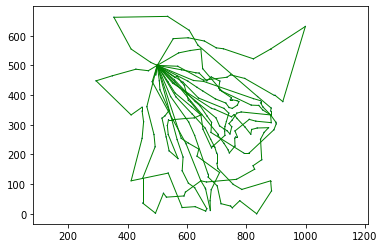

Run: 20 with random seed 20
End of run 20 with best solution quality 12744.945920872196 total evaluations: 5575313.041234146


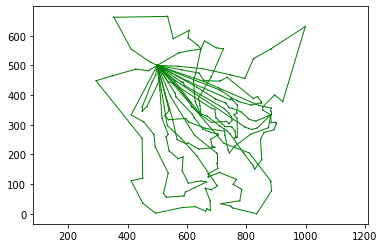

In [17]:
import os 
from natsort import natsorted, ns

# Loop
# %cd /content/drive/MyDrive/CS106.M11.KHCL/source
pathToBenchmark = '.\evrp-benchmark-set'

listPath = [os.path.join(pathToBenchmark, file) for file in os.listdir(pathToBenchmark)]
listPath = natsorted(listPath, alg=ns.IGNORECASE)
limit_index = 8

for index, filePath in enumerate(listPath):
  if index > limit_index:
    break

  print('Running: ' + filePath)
  main(filePath)